In [1]:
import pyarrow.dataset as ds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
from statsmodels.stats import stattools
from scipy import stats
import seaborn as sns

In [3]:
from RiskLabAI.controller import Controller

# initialize controller
controller = Controller()

In [4]:
import optuna
from optuna.samplers import TPESampler
import torch
print(torch.backends.mps.is_available())

True


# Load Datasets

In [5]:
#Asset under study
ticker = 'BTCUSDT'

# define dataset
dataset = ds.dataset(
    "/Users/bobet/Documents/Code Repository/Trading-Systems/_datasets",
    format="parquet")

# push filter into Arrow scan (faster, uses partition pruning if possible)
table = dataset.to_table(filter=ds.field("symbol") == ticker)

# convert to pandasssss
df = table.to_pandas()
df.tail()

,symbol,ts_ms,iso_utc,ohlc_ts_open,ohlc_open,ohlc_high,ohlc_low,ohlc_close,ohlc_volume,ohlc_ts_close,...,tr_volume_base,tr_volume_quote,tr_vwap,tr_buy_sell_imbalance,spot_price,perp_mark_price,basis_abs,basis_pct,funding_rate,next_funding_time_ms
29396,BTCUSDT,1757235398782,2025-09-07T08:56:38.782629+00:00,1757235360000,111064.48,111064.49,111056.56,111056.57,2.20840,1757235419999,...,13.34440,1.482838e+06,111120.587469,-0.743010,111056.56,111012.000000,-44.560000,-0.000401,0.000057,1757260800000
29397,BTCUSDT,1757235458832,2025-09-07T08:57:38.832643+00:00,1757235420000,111056.57,111056.57,111056.56,111056.57,1.36043,1757235479999,...,14.19905,1.577770e+06,111118.009205,-0.770104,111056.57,111009.024457,-47.545543,-0.000428,0.000057,1757260800000
29398,BTCUSDT,1757235518882,2025-09-07T08:58:38.882621+00:00,1757235480000,111056.56,111056.57,111056.56,111056.57,1.23647,1757235539999,...,8.16041,9.065610e+05,111092.576224,-0.587442,111056.57,111003.800000,-52.770000,-0.000475,0.000058,1757260800000
29399,BTCUSDT,1757235578942,2025-09-07T08:59:38.942235+00:00,1757235540000,111056.57,111071.25,111056.56,111071.25,8.48946,1757235599999,...,7.84490,8.714298e+05,111082.330495,-0.861344,111071.25,111035.600000,-35.650000,-0.000321,0.000058,1757260800000
29400,BTCUSDT,1757235638992,2025-09-07T09:00:38.992628+00:00,1757235600000,111071.25,111071.25,111071.24,111071.25,2.93395,1757235659999,...,8.17185,9.075995e+05,111064.142909,-0.800718,111071.25,111028.000000,-43.250000,-0.000389,0.000058,1757260800000


In [6]:
#features
df.columns

Index(['symbol', 'ts_ms', 'iso_utc', 'ohlc_ts_open', 'ohlc_open', 'ohlc_high',
       'ohlc_low', 'ohlc_close', 'ohlc_volume', 'ohlc_ts_close', 'ohlc_trades',
       'ohlc_taker_base', 'ohlc_taker_quote', 'l1_bid', 'l1_ask', 'l1_mid',
       'l1_spread', 'l1_bid_qty', 'l1_ask_qty', 'l1_imbalance', 'l2_bid_depth',
       'l2_ask_depth', 'l2_depth_asymmetry', 'l2_bid_vwap', 'l2_ask_vwap',
       'l2_bid_slope', 'l2_ask_slope', 'tr_volume_base', 'tr_volume_quote',
       'tr_vwap', 'tr_buy_sell_imbalance', 'spot_price', 'perp_mark_price',
       'basis_abs', 'basis_pct', 'funding_rate', 'next_funding_time_ms'],
      dtype='object')

In [7]:
sample_size = df.count()[0]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29401 entries, 0 to 29400
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   symbol                 29401 non-null  object 
 1   ts_ms                  29401 non-null  int64  
 2   iso_utc                29401 non-null  object 
 3   ohlc_ts_open           29401 non-null  int64  
 4   ohlc_open              29401 non-null  float64
 5   ohlc_high              29401 non-null  float64
 6   ohlc_low               29401 non-null  float64
 7   ohlc_close             29401 non-null  float64
 8   ohlc_volume            29401 non-null  float64
 9   ohlc_ts_close          29401 non-null  int64  
 10  ohlc_trades            29401 non-null  int64  
 11  ohlc_taker_base        29401 non-null  float64
 12  ohlc_taker_quote       29401 non-null  float64
 13  l1_bid                 29401 non-null  float64
 14  l1_ask                 29401 non-null  float64
 15  l1

## Raw Features

### General
- **symbol**: Trading pair identifier (e.g., BTCUSDT).  
- **ts_ms**: Data timestamp in milliseconds (epoch time).  
- **iso_utc**: Data timestamp in human-readable UTC format.  

### OHLC Data (Candlestick)
- **ohlc_ts_open**: Opening timestamp for the candlestick period.  
- **ohlc_open**: Opening price of the candlestick.  
- **ohlc_high**: Highest price within the candlestick.  
- **ohlc_low**: Lowest price within the candlestick.  
- **ohlc_close**: Closing price of the candlestick.  
- **ohlc_volume**: Trading volume during the candlestick (base asset units).  
- **ohlc_ts_close**: Closing timestamp for the candlestick period.  
- **ohlc_trades**: Number of trades in the candlestick.  
- **ohlc_taker_base**: Base asset volume traded by takers (aggressors).  
- **ohlc_taker_quote**: Quote asset volume traded by takers.  

### Level 1 Order Book (Top of Book)
- **l1_bid**: Best bid price (highest buy order).  
- **l1_ask**: Best ask price (lowest sell order).  
- **l1_mid**: Midpoint price between bid and ask.  
- **l1_spread**: Difference between best ask and bid (ask - bid).  
- **l1_bid_qty**: Quantity available at best bid.  
- **l1_ask_qty**: Quantity available at best ask.  
- **l1_imbalance**: Order book imbalance at Level 1 = (bid_qty – ask_qty) / (bid_qty + ask_qty).  

### Level 2 Order Book (Depth of Market)
- **l2_bid_depth**: Total buy-side liquidity across multiple bid levels.  
- **l2_ask_depth**: Total sell-side liquidity across multiple ask levels.  
- **l2_depth_asymmetry**: Relative difference between bid and ask depth.  
- **l2_bid_vwap**: Volume-weighted average bid price across order book levels.  
- **l2_ask_vwap**: Volume-weighted average ask price across order book levels.  
- **l2_bid_slope**: Measure of how steeply bid prices rise with quantity (liquidity gradient).  
- **l2_ask_slope**: Measure of how steeply ask prices rise with quantity.  

### Trade Data
- **tr_volume_base**: Total traded volume in base asset.  
- **tr_volume_quote**: Total traded volume in quote asset.  
- **tr_vwap**: Trade volume-weighted average price.  
- **tr_buy_sell_imbalance**: Difference between buy-initiated and sell-initiated trade volumes.  

### Derived Prices
- **spot_price**: Current spot market price.  
- **perp_mark_price**: Mark price used in perpetual futures to avoid manipulation.  
- **basis_abs**: Absolute difference between perpetual mark price and spot price.  
- **basis_pct**: Percentage difference between perpetual mark price and spot price.  
- **funding_rate**: Periodic payment rate between long and short positions in perpetual contracts.  
- **next_funding_time_ms**: Timestamp (ms) of the next funding event.  

## Data hygiene & storage

✔ Why: storage efficiency + ordering. A 10GB dataset may shrink to ~3-4GB when optimized.

In [8]:
# Ensure correct dtypes (saves memory on 10GB dataset)
dtype_map = {
    "symbol": "category",
    "ohlc_open": "float32", "ohlc_high": "float32", "ohlc_low": "float32", "ohlc_close": "float32",
    "ohlc_volume": "float32", "ohlc_trades": "int32",
    "ohlc_taker_base": "float32", "ohlc_taker_quote": "float32",
    "l1_bid": "float32", "l1_ask": "float32", "l1_mid": "float32", "l1_spread": "float32",
    "l1_bid_qty": "float32", "l1_ask_qty": "float32", "l1_imbalance": "float32",
    "l2_bid_depth": "float32", "l2_ask_depth": "float32", "l2_depth_asymmetry": "float32",
    "l2_bid_vwap": "float32", "l2_ask_vwap": "float32",
    "l2_bid_slope": "float32", "l2_ask_slope": "float32",
    "tr_volume_base": "float32", "tr_volume_quote": "float32", "tr_vwap": "float32",
    "tr_buy_sell_imbalance": "float32",
    "spot_price": "float32", "perp_mark_price": "float32",
    "basis_abs": "float32", "basis_pct": "float32", "funding_rate": "float32"
}

df = df.astype(dtype_map)

# Make sure timestamp is datetime
df["iso_utc"] = pd.to_datetime(df["iso_utc"])
df = df.set_index("iso_utc").sort_index()


#Intergrity Check
# Drop duplicates, check ordering
df = df[~df.index.duplicated(keep="first")].sort_index()

# Sanity checks for OHLC
mask = (
    (df["ohlc_low"] <= df["ohlc_open"]) &
    (df["ohlc_low"] <= df["ohlc_close"]) &
    (df["ohlc_high"] >= df["ohlc_open"]) &
    (df["ohlc_high"] >= df["ohlc_close"])
)
df = df[mask]

# Check non-negative volumes
df = df[df["ohlc_volume"] >= 0]

In [44]:
param_db_filename = 'params_resampling-scheme.json'
# Open and load JSON file

def load_param_resampling_db(file_name):
    with open(file_name, "r") as f:
        df_params = json.load(f)
    return df_params

db_resampling_params = load_param_resampling_db(param_db_filename)
db_resampling_params

[{'ticker': 'BTCUSDT',
  'Sampling_Scheme': 'expected_tick_imbalance_bars',
  'n_trials': 50,
  'n_samples': 29401,
  'Shapiro-Wilk_statistic': 0.860134363,
  'Shapiro-Wilk_pvalue': 0.0,
  'window_size_for_expected_n_ticks_estimation': 5,
  'window_size_for_expected_imbalance_estimation': 10000,
  'initial_estimate_of_expected_n_ticks_in_bar': 20000,
  'batch_size': 1000000},
 {'ticker': 'BTCUSDT',
  'Sampling_Scheme': 'expected_volume_imbalance_bars',
  'n_trials': 50,
  'n_samples': 29401,
  'Shapiro-Wilk_statistic': 0.966333091,
  'Shapiro-Wilk_pvalue': 0.870860279,
  'window_size_for_expected_n_ticks_estimation': 5,
  'window_size_for_expected_imbalance_estimation': 10000,
  'initial_estimate_of_expected_n_ticks_in_bar': 20000,
  'batch_size': 1000000},
 {'ticker': 'BTCUSDT',
  'Sampling_Scheme': 'expected_dollar_imbalance_bars',
  'n_trials': 50,
  'n_samples': 29401,
  'Shapiro-Wilk_statistic': 0.961657166,
  'Shapiro-Wilk_pvalue': 0.832820237,
  'window_size_for_expected_n_ticks

In [60]:
#load best parameters in the resampling database
def db_resampling_best_params(_sampling_method,db_params):
    db = pd.DataFrame(db_params)
    db = db.loc[db['Sampling_Scheme'] ==_sampling_method]

    # Sort by 'n_samples' first, then by 'Shapiro-Wilk_pvalue', then by 'Shapiro-Wilk_statistic'
    db = db.sort_values(
        by=['n_samples', 'Shapiro-Wilk_pvalue', 'Shapiro-Wilk_statistic'],
        ascending=[True, True, True])   # example: n_samples ↑, pvalue ↓, stat ↓

    return db.tail(1).to_dict(orient="records")[0]

In [61]:
db_best_params = db_resampling_best_params(_sampling_method='expected_dollar_imbalance_bars',db_params=db_resampling_params)
db_best_params

{'ticker': 'BTCUSDT',
 'Sampling_Scheme': 'expected_dollar_imbalance_bars',
 'n_trials': 200,
 'n_samples': 29401,
 'Shapiro-Wilk_statistic': 0.9999974966049194,
 'Shapiro-Wilk_pvalue': 0.9969781962478527,
 'window_size_for_expected_n_ticks_estimation': 48,
 'window_size_for_expected_imbalance_estimation': 2945,
 'initial_estimate_of_expected_n_ticks_in_bar': 3211,
 'batch_size': 745904}

In [12]:
# import pandas as pd

# df = pd.read_csv("params_resampling-scheme.csv")

# df.to_json("params_resampling-scheme.json", orient="records", indent=2)

# print("✅ Saved params_resampling-scheme.json")

29401

# Utilily Functions

## Helper Functions

Summed (additive counts / volumes)

We sum over the ticks inside each bar:
	•	ohlc_trades
	•	ohlc_taker_base
	•	ohlc_taker_quote
	•	tr_volume_base
	•	tr_volume_quote

⸻

Last (state-like snapshots, take the latest tick in the bar)

We forward-fill within the bar only, then take the last available value:
	•	l1_bid, l1_ask, l1_mid, l1_spread
	•	l1_bid_qty, l1_ask_qty, l1_imbalance
	•	l2_bid_depth, l2_ask_depth, l2_depth_asymmetry
	•	l2_bid_vwap, l2_ask_vwap, l2_bid_slope, l2_ask_slope
	•	spot_price, perp_mark_price
	•	basis_abs, basis_pct
	•	funding_rate, next_funding_time_ms

(These are “levels” or “state variables” you’d want at the bar close.)

⸻

Mean (averaged inside the bar)
	•	tr_buy_sell_imbalance

⸻

Weighted mean (value × volume / total volume)
	•	tr_vwap (weighted by tr_volume_base)

(This is the standard definition of VWAP: average trade price weighted by base-asset volume.)

In [13]:
from __future__ import annotations

from typing import Callable, Iterable, Mapping, Optional


# --- replace the helper entirely ---
def _to_utc_series(s: pd.Series, *, assume_unit_ms: bool | None = None) -> pd.Series:
    """
    Coerce a time-like Series to timezone-aware UTC pandas Timestamps.
    - If the Series is integer-like, interpret as Unix milliseconds.
    - If tz-aware, convert to UTC (no-op if already UTC).
    - If naive datetime or object, parse and localize to UTC.
    """


    # Auto-detect integer-ms if not explicitly passed
    if assume_unit_ms is None:
        assume_unit_ms = pd.api.types.is_integer_dtype(s)

    if assume_unit_ms:
        return pd.to_datetime(s.astype("int64"), unit="ms", utc=True)

    if pd.api.types.is_datetime64tz_dtype(s):
        # Already tz-aware: just convert to UTC
        return s.dt.tz_convert("UTC")

    # Covers naive datetime64[ns], object, string, etc.
    return pd.to_datetime(s, utc=True, errors="coerce")


def _ensure_datetime_naive_ns_utc(s_aware: pd.Series) -> pd.Series:
    """
    Convert timezone-aware UTC timestamps to naive datetime64[ns] in UTC
    (i.e., drop tz info). This is convenient for binning with pd.cut.
    """
    if not pd.api.types.is_datetime64tz_dtype(s_aware.dtype):
        raise TypeError("Expected tz-aware datetime64[ns, UTC] series.")
    return s_aware.dt.tz_convert("UTC").dt.tz_localize(None)


def _default_agg_spec(feature_cols: Iterable[str]) -> tuple[dict[str, str], dict[str, tuple[str, str]]]:
    """
    Build default aggregation maps given the available columns.
    Returns (agg_spec, weighted_cols).
    """
    vol_sum = {
        'ohlc_trades','ohlc_taker_base','ohlc_taker_quote',
        'tr_volume_base','tr_volume_quote'
    }
    last_like = {
        'l1_bid','l1_ask','l1_mid','l1_spread',
        'l1_bid_qty','l1_ask_qty','l1_imbalance',
        'l2_bid_depth','l2_ask_depth','l2_depth_asymmetry',
        'l2_bid_vwap','l2_ask_vwap','l2_bid_slope','l2_ask_slope',
        'spot_price','perp_mark_price','basis_abs','basis_pct',
        'funding_rate','next_funding_time_ms'
    }
    mean_like = {'tr_buy_sell_imbalance'}

    agg: dict[str, str] = {}
    for c in feature_cols:
        if c in vol_sum:
            agg[c] = "sum"
        elif c in last_like:
            agg[c] = "last"
        elif c in mean_like:
            agg[c] = "mean"

    weighted: dict[str, tuple[str, str]] = {}
    # VWAP-like default if both columns exist
    if 'tr_vwap' in feature_cols and 'tr_volume_base' in feature_cols:
        weighted['tr_vwap'] = ('tr_vwap', 'tr_volume_base')

    return agg, weighted


def attach_extra_features_to_bars(
    df: pd.DataFrame,
    bars: pd.DataFrame,
    feature_cols: list[str],
    *,
    time_col: str = "ts_ms",
    bar_time_col: str = "Date Time",
    agg_spec: Optional[Mapping[str, str | Callable]] = None,
    weighted_cols: Optional[Mapping[str, tuple[str, str]]] = None,
    drop_empty: bool = False,
) -> pd.DataFrame:
    """
    Aggregate tick-level features from `df` into expected tick-imbalance bars `bars`.

    For each bar i with close time T_i (bars[bar_time_col]) and previous close T_{i-1},
    aggregate df rows whose time is in (T_{i-1}, T_i] (left-open, right-closed).
    The first bar uses (-inf, T_0].

    Aggregations:
      * `agg_spec`: mapping {col: reduction}, where reduction is a pandas
        reduction name (e.g., 'sum','mean','last','max','min') or a callable.
      * `weighted_cols`: mapping {out_col: (value_col, weight_col)} computing
        sum(value*weight)/sum(weight) per bar. When the weight sum is zero (or
        no rows fall into the interval), result is NaN.

    Timestamp handling:
      * Robustly coerces both `df[time_col]` and `bars[bar_time_col]` to tz-aware
        UTC timestamps. Integer ms are supported (interpreted as Unix ms).
      * Sorting is applied internally; original `bars` order and index are preserved.

    Special rules:
      * For columns aggregated with 'last', values are forward-filled *within the
        same bar only* before taking the last, to make 'last' robust against
        missing ticks inside the bar. No forward filling across bars.
      * Empty intervals produce NaNs. Set `drop_empty=True` to drop those bars
        **from the returned DataFrame** (i.e., fewer rows than input `bars`).

    Implementation notes:
      * Uses a categorical bin index via `pd.cut` with bins (-inf, T_0], (T_0, T_1], ...
        to avoid O(N*M) loops.
      * Preserves the input `bars` index and order (unless `drop_empty=True`).
      * New columns are named `{col}_bar`.

    Parameters
    ----------
    df : pd.DataFrame
        Tick-level data with at least `time_col` and requested feature columns.
    bars : pd.DataFrame
        Bar dataframe with at least `bar_time_col` and a row per bar close time.
    feature_cols : list[str]
        Columns from `df` to aggregate (some may be produced via `weighted_cols`).
    time_col : str, default 'ts_ms'
        Column in `df` containing tick timestamps (int ms or datetime-like).
    bar_time_col : str, default 'Date Time'
        Column in `bars` containing bar close timestamps (tz-aware or UTC-naive).
    agg_spec : dict[str, str | Callable] | None
        Map of simple aggregations for selected columns (see above).
        If None, sensible defaults are used (per the prompt).
    weighted_cols : dict[str, tuple[str, str]] | None
        Map for weighted averages: {out_col: (value_col, weight_col)}.
        Defaults include tr_vwap weighted by tr_volume_base if available.
    drop_empty : bool, default False
        If True, rows where *all new aggregated columns* are NaN are dropped
        from the returned DataFrame.

    Returns
    -------
    pd.DataFrame
        A copy of `bars` with additional aggregated columns appended.

    Raises
    ------
    KeyError
        If required columns are missing in `df` or `bars`.
    TypeError / ValueError
        On invalid dtypes or aggregation specifications.
    """
    # --- Parameter validation -------------------------------------------------
    if not isinstance(df, pd.DataFrame):
        raise TypeError("`df` must be a pandas DataFrame.")
    if not isinstance(bars, pd.DataFrame):
        raise TypeError("`bars` must be a pandas DataFrame.")
    if not isinstance(feature_cols, (list, tuple)):
        raise TypeError("`feature_cols` must be a list of column names.")

    for col in [time_col]:
        if col not in df.columns:
            raise KeyError(f"`df` is missing required time column: {col!r}")
    if bar_time_col not in bars.columns:
        raise KeyError(f"`bars` is missing required column: {bar_time_col!r}")

    # Determine default agg/weighted if not provided
    if agg_spec is None or weighted_cols is None:
        dflt_agg, dflt_weighted = _default_agg_spec(feature_cols)
        agg_spec = dflt_agg if agg_spec is None else dict(agg_spec)
        # merge defaults with user-provided, user overrides defaults
        weighted_cols = dflt_weighted | (weighted_cols or {})

    # Validate agg_spec values
    valid_reductions = {
        "sum", "mean", "last", "first", "min", "max", "median", "std", "var"
    }
    for k, v in agg_spec.items():
        if not (callable(v) or (isinstance(v, str) and v in valid_reductions)):
            raise ValueError(
                f"agg_spec[{k!r}] must be a callable or one of {sorted(valid_reductions)}; got {v!r}"
            )

    # Validate presence of required columns in df for simple aggs
    simple_cols = [c for c in feature_cols if c in agg_spec]
    missing_simple = [c for c in simple_cols if c not in df.columns]
    if missing_simple:
        raise KeyError(f"`df` is missing required feature columns for agg_spec: {missing_simple}")

    # Validate weighted columns
    weighted_cols = dict(weighted_cols or {})
    for out_col, (val_col, w_col) in weighted_cols.items():
        if val_col not in df.columns or w_col not in df.columns:
            raise KeyError(
                f"Weighted column {out_col!r} requires value={val_col!r} and weight={w_col!r} to be present in `df`."
            )

    # Some feature_cols might be produced outputs (e.g., 'tr_vwap'); ensure we'll emit them
    out_cols = set(simple_cols) | set(weighted_cols.keys())
    if not out_cols:
        raise ValueError("No aggregations inferred. Check `feature_cols`, `agg_spec`, or `weighted_cols`.")

    # --- Timestamp coercion ---------------------------------------------------
    # df times
    df_ts = _to_utc_series(df[time_col])  # safe: auto-detects int-ms, tz-aware, or naive
    if df_ts.isna().any():
        bad = int(df_ts.isna().sum())
        raise ValueError(f"{bad} rows in `df[{time_col!r}]` could not be parsed to timestamps.")

    # bars times
    bars_ts = _to_utc_series(bars[bar_time_col], assume_unit_ms=False)
    if bars_ts.isna().any():
        bad = int(bars_ts.isna().sum())
        raise ValueError(f"{bad} rows in `bars[{bar_time_col!r}]` could not be parsed to timestamps.")

    # Sort df by time; keep bars original order for final alignment
    df_ord = df_ts.sort_values(kind="mergesort").index
    df_sorted = df.loc[df_ord].copy()
    df_ts_sorted = df_ts.loc[df_ord]

    # Sort bars by time to build bins; remember mapping back to original order
    bars_ts_sorted = bars_ts.sort_values(kind="mergesort")
    bars_sorted_index = bars_ts_sorted.index  # index labels of bars in ascending time
    n_bars = len(bars_sorted_index)

    # Convert both to naive datetime64[ns] for pd.cut
    df_ts_naive = _ensure_datetime_naive_ns_utc(df_ts_sorted)
    bars_ts_naive_sorted = _ensure_datetime_naive_ns_utc(bars_ts_sorted)

    # --- Build categorical bin labels: (-inf, T0], (T0, T1], ..., (T_{n-1}, T_n] ---
    # Use Timestamp.min as practical -inf for datetime bins.
    # --- Build categorical bin labels: (-inf, T0], (T0, T1], ..., (T_{n-1}, T_n] ---
    if n_bars == 0:
        return bars.copy()

    # Keep datetime64[ns] dtype by constructing a DatetimeIndex
    bins_idx = pd.DatetimeIndex([pd.Timestamp.min]).append(
        pd.DatetimeIndex(bars_ts_naive_sorted)
    )

    # (Optional but helpful) validate bins are increasing; duplicates create zero-width bins
    if not bins_idx.is_monotonic_increasing:
        # We sorted bars earlier, so this should only trip if there are NaNs (already checked) or weird inputs
        raise ValueError("Bar close times are not monotonic after normalization.")

    labels = pd.Index(np.arange(n_bars), name="_bar_pos")  # positions in SORTED bar order

    cat = pd.cut(
        df_ts_naive,
        bins=bins_idx,           # <- DatetimeIndex keeps dtype correct
        labels=labels,
        right=True,
        include_lowest=True,
    )

    # Groupby helper on the categorical bar position
    gb = df_sorted.groupby(cat, observed=True, sort=False)

    # --- Prepare aggregations -------------------------------------------------
    results = []

    # 1) Handle 'last' columns with intra-bar forward-fill (no cross-bar carry)
    last_cols = [c for c in simple_cols if agg_spec[c] == "last"]
    if last_cols:
        # Forward-fill within each bar only
        last_block = df_sorted[last_cols].copy()
        last_block = last_block.groupby(cat, observed=True).ffill()
        last_agg = last_block.groupby(cat, observed=True).last()
        last_agg.index = last_agg.index.astype("Int64")  # groupby over Categorical yields categorical index; make it integer-ish
        last_agg = last_agg.reindex(labels.astype("Int64"))  # include empty bars as NaN
        last_agg.columns = [f"{c}_bar" for c in last_agg.columns]
        results.append(last_agg)

    # 2) Other simple reductions (sum/mean/min/max/etc.), excluding 'last'
    other_cols = [c for c in simple_cols if agg_spec[c] != "last"]
    if other_cols:
        # Build a column-wise aggregation map
        agg_map: dict[str, str | Callable] = {c: agg_spec[c] for c in other_cols}
        other_agg = gb.agg(agg_map)
        # When aggregating multiple functions, gb.agg returns DataFrame; else Series
        if isinstance(other_agg, pd.Series):
            other_agg = other_agg.to_frame()
        # Ensure full set of bars (inject empty intervals as NaN)
        other_agg.index = other_agg.index.astype("Int64")
        other_agg = other_agg.reindex(labels.astype("Int64"))
        other_agg.columns = [f"{c}_bar" for c in other_agg.columns]
        results.append(other_agg)

    # 3) Weighted averages
    for out_col, (vcol, wcol) in weighted_cols.items():
        if out_col not in feature_cols:
            continue

        vals = df_sorted[vcol]
        wgts = df_sorted[wcol]

        # Compute numerator and denominator as Series, then group them directly.
        prod = vals * wgts  # may have name=None; that's fine since we group the series itself

        num = prod.groupby(cat, observed=True).sum(min_count=1)
        den = wgts.groupby(cat, observed=True).sum(min_count=1)

        # Align to full set of bars (include empty bars as NaN)
        num.index = num.index.astype("Int64")
        den.index = den.index.astype("Int64")
        num = num.reindex(labels.astype("Int64"))
        den = den.reindex(labels.astype("Int64"))

        wavg = (num / den).replace([np.inf, -np.inf], np.nan)
        wavg = wavg.rename(f"{out_col}_bar").to_frame()

        results.append(wavg)

    # If nothing to concatenate (shouldn't happen), return bars copy
    if not results:
        return bars.copy()

    # Concatenate all aggregates; index currently is bar position in *sorted* order (0..n_bars-1)
    agg_df = pd.concat(results, axis=1)

    # Replace +/- inf with NaN (e.g., divisions)
    agg_df = agg_df.replace([np.inf, -np.inf], np.nan)

    # Map from sorted bar positions → original bars index labels
    # positions: 0..n_bars-1 correspond to bars_sorted_index order
    agg_df.index = pd.Index(bars_sorted_index, name=bars.index.name)

    # Reindex to original bars order
    agg_df = agg_df.reindex(bars.index)

    # Assemble result
    out = bars.copy()
    out = pd.concat([out, agg_df], axis=1)

    if drop_empty:
        new_cols = [c for c in out.columns if c.endswith("_bar")]
        mask_all_nan = out[new_cols].isna().all(axis=1)
        out = out.loc[~mask_all_nan]

    return out

In [14]:
log_return = lambda s: np.log(s).diff().dropna()

# Sampling schemes

In financial time series, sampling schemes determine how raw tick-level data (individual trades) are aggregated into bars (OHLC structures). Traditional time bars sample at fixed calendar intervals, but these often distort statistical properties by oversampling quiet periods and undersampling volatile ones.

To address this, López de Prado (2018) introduced alternative, `event-driven` bars that adapt to market activity. In this work, the focus is on:

- `Expected Imbalance Bars (EIBs)`
EIBs close a bar when the accumulated buy–sell volume imbalance exceeds an expected threshold, estimated dynamically from historical data. This produces bars of variable length that contain approximately equal amounts of information, improving stationarity and normality of returns. EIBs are particularly well suited for machine learning tasks that rely on balanced and stable input data.

- `Expected Run Bars (ERBs)`
ERBs close a bar when the number of consecutive buy or sell trades (a “run”) surpasses an expected run length, again estimated adaptively. This highlights periods of persistent order flow, often associated with informed trading or liquidity grabs. ERBs are especially valuable for detecting market microstructure patterns, such as those studied in Smart Money Concepts (SMC).

In [15]:
features = [
    'ohlc_trades','ohlc_taker_base','ohlc_taker_quote',
    'l1_bid','l1_ask','l1_mid','l1_spread',
    'l1_bid_qty','l1_ask_qty','l1_imbalance',
    'l2_bid_depth','l2_ask_depth','l2_depth_asymmetry',
    'l2_bid_vwap','l2_ask_vwap','l2_bid_slope','l2_ask_slope',
    'tr_volume_base','tr_volume_quote','tr_vwap','tr_buy_sell_imbalance',
    'spot_price','perp_mark_price','basis_abs','basis_pct',
    'funding_rate','next_funding_time_ms'
]


In [16]:
df

,symbol,ts_ms,ohlc_ts_open,ohlc_open,ohlc_high,ohlc_low,ohlc_close,ohlc_volume,ohlc_ts_close,ohlc_trades,...,tr_volume_base,tr_volume_quote,tr_vwap,tr_buy_sell_imbalance,spot_price,perp_mark_price,basis_abs,basis_pct,funding_rate,next_funding_time_ms
iso_utc,,,,,,,,,,,,,,,,,,,,,
2025-08-17 15:45:47.575950+00:00,BTCUSDT,1755445547575,1755445500000,118248.593750,118251.351562,118248.578125,118251.351562,0.75580,1755445559999,242,...,4.56246,5.392974e+05,118203.203125,0.488706,118251.343750,118195.445312,-55.892235,-0.000473,0.000017,1755446400000
2025-08-17 15:46:47.606265+00:00,BTCUSDT,1755445607606,1755445560000,118251.351562,118251.351562,118234.523438,118234.531250,5.14589,1755445619999,671,...,5.28487,6.248164e+05,118227.398438,0.327650,118234.531250,118174.101562,-60.430000,-0.000511,0.000017,1755446400000
2025-08-17 15:47:47.643040+00:00,BTCUSDT,1755445667643,1755445620000,118234.523438,118234.531250,118234.523438,118234.531250,2.35213,1755445679999,180,...,5.56556,6.580366e+05,118233.671875,0.493460,118234.523438,118189.703125,-44.820000,-0.000379,0.000017,1755446400000
2025-08-17 15:48:47.662644+00:00,BTCUSDT,1755445727662,1755445680000,118234.531250,118234.531250,118234.523438,118234.523438,6.03409,1755445739999,314,...,7.24521,8.566891e+05,118242.132812,-0.299805,118234.523438,118184.718750,-49.797905,-0.000421,0.000017,1755446400000
2025-08-17 15:49:47.702649+00:00,BTCUSDT,1755445787702,1755445740000,118234.531250,118234.531250,118234.523438,118234.523438,1.28289,1755445799999,163,...,7.78536,9.205612e+05,118242.601562,-0.385300,118234.523438,118180.898438,-53.619999,-0.000454,0.000017,1755446400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-07 08:56:38.782629+00:00,BTCUSDT,1757235398782,1757235360000,111064.476562,111064.492188,111056.562500,111056.570312,2.20840,1757235419999,300,...,13.34440,1.482838e+06,111120.585938,-0.743010,111056.562500,111012.000000,-44.560001,-0.000401,0.000057,1757260800000
2025-09-07 08:57:38.832643+00:00,BTCUSDT,1757235458832,1757235420000,111056.570312,111056.570312,111056.562500,111056.570312,1.36043,1757235479999,118,...,14.19905,1.577770e+06,111118.007812,-0.770104,111056.570312,111009.023438,-47.545544,-0.000428,0.000057,1757260800000
2025-09-07 08:58:38.882621+00:00,BTCUSDT,1757235518882,1757235480000,111056.562500,111056.570312,111056.562500,111056.570312,1.23647,1757235539999,80,...,8.16041,9.065610e+05,111092.578125,-0.587442,111056.570312,111003.796875,-52.770000,-0.000475,0.000058,1757260800000


## Expected Imbalance Bars

In [17]:
data = df.copy()
data = data.loc[:, ['symbol', 'ohlc_close', 'ohlc_volume']]
#rename column
data.reset_index(inplace=True) 
data.set_index('symbol', inplace=True)
data.columns = ['date', 'price', 'volume']
data.head()

,date,price,volume
symbol,,,
BTCUSDT,2025-08-17 15:45:47.575950+00:00,118251.351562,0.75580
BTCUSDT,2025-08-17 15:46:47.606265+00:00,118234.531250,5.14589
BTCUSDT,2025-08-17 15:47:47.643040+00:00,118234.531250,2.35213
BTCUSDT,2025-08-17 15:48:47.662644+00:00,118234.523438,6.03409
BTCUSDT,2025-08-17 15:49:47.702649+00:00,118234.523438,1.28289


### Imbalance Tick Bars

In [18]:
EIB_ticks = controller.handle_input_command(
    method_name="expected_tick_imbalance_bars",
    method_arguments={
        "window_size_for_expected_n_ticks_estimation": 5,
        "window_size_for_expected_imbalance_estimation": 10000,
        "initial_estimate_of_expected_n_ticks_in_bar": 2000,
    },
    input_data=data,
    batch_size=1_000_000,
)

#Map / Aggreagate to other features

EIB_ticks_with_orderbook = attach_extra_features_to_bars(
    df,
    EIB_ticks,
    feature_cols=features,
    # optional overrides:
    # agg_spec={"spot_price": "mean"},  # if you want different aggregation
    # weighted_cols={"tr_vwap": ("tr_vwap", "tr_volume_base")},
    drop_empty=False
)

EIB_ticks_with_orderbook.head()
EIB_ticks.head()



Processing batch 0 with size 29401


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold
0,2025-08-19 08:02:47.952667+00:00,2000,118251.351562,118316.007812,114574.507812,114946.593750,7135.756033,2961.876805,4173.879228,2000,8.280297e+08,5.784036
1,2025-08-19 08:08:48.202938+00:00,2006,114940.000000,114940.000000,114804.000000,114804.000000,39.409420,0.000000,39.409420,6,4.526917e+06,5.784036
2,2025-08-19 08:52:49.842643+00:00,2050,114816.656250,115263.757812,114805.773438,115263.757812,282.337731,199.016580,83.321151,44,3.247061e+07,7.813768
3,2025-08-19 08:53:49.882956+00:00,2051,115203.453125,115203.453125,115203.453125,115203.453125,5.272910,0.000000,5.272910,1,6.074575e+05,0.030384
4,2025-08-19 08:54:49.922659+00:00,2052,115277.421875,115277.421875,115277.421875,115277.421875,9.837890,9.837890,0.000000,1,1.134087e+06,0.273591


### Imbalance Volume Bars

In [19]:
EIB_vol = controller.handle_input_command(
    method_name="expected_volume_imbalance_bars",
    method_arguments={
        "window_size_for_expected_n_ticks_estimation": 5,
        "window_size_for_expected_imbalance_estimation": 10000,
        "initial_estimate_of_expected_n_ticks_in_bar": 2000,
    },
    input_data=data,
    batch_size=1_000_000,
)

#Map / Aggreagate to other features

EIB_vol_with_orderbook = attach_extra_features_to_bars(
    df,
    EIB_vol,
    feature_cols=features,
    # optional overrides:
    # agg_spec={"spot_price": "mean"},  # if you want different aggregation
    # weighted_cols={"tr_vwap": ("tr_vwap", "tr_volume_base")},
    drop_empty=False
)

EIB_vol_with_orderbook.head()
EIB_vol.head()

Processing batch 0 with size 29401


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold
0,2025-08-19 08:06:48.122659+00:00,2004,118251.351562,118316.007812,114574.507812,114860.343750,7160.604382,2961.876805,4198.727577,2004,8.308845e+08,1225.412327
1,2025-08-22 15:36:40.842883+00:00,6771,114856.000000,116985.976562,111700.000000,116859.382812,28416.158416,14856.855396,13559.303020,4767,3.234002e+09,1279.366725
2,2025-08-24 19:36:35.942654+00:00,9889,116824.937500,117409.593750,112963.906250,112963.906250,16566.511754,7429.400280,9137.111474,3118,1.914037e+09,1383.160318
3,2025-08-24 19:37:35.982667+00:00,9890,111075.546875,111075.546875,111075.546875,111075.546875,905.008423,0.000000,905.008423,1,1.005243e+08,837.071623
4,2025-08-25 10:55:09.882759+00:00,10807,111992.039062,113664.000000,111011.812500,111011.812500,8601.936594,3831.012761,4770.923833,917,9.692402e+08,910.603257


### Imbalance Dollar Bars

In [20]:
EIB_dollar = controller.handle_input_command(
    method_name="expected_dollar_imbalance_bars",
    method_arguments={
        "window_size_for_expected_n_ticks_estimation": 6,
        "window_size_for_expected_imbalance_estimation": 1254,
        "initial_estimate_of_expected_n_ticks_in_bar": 4191,
    },
    input_data=data,
    batch_size=1_000_000,
)

#Map / Aggreagate to other features

EIB_dollar_with_orderbook = attach_extra_features_to_bars(
    df,
    EIB_dollar,
    feature_cols=features,
    # optional overrides:
    # agg_spec={"spot_price": "mean"},  # if you want different aggregation
    # weighted_cols={"tr_vwap": ("tr_vwap", "tr_volume_base")},
    drop_empty=False
)

EIB_dollar_with_orderbook.head()
EIB_dollar.head()


Processing batch 0 with size 29401


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold
0,2025-08-20 20:35:06.722810+00:00,4191,118251.351562,118316.007812,112398.906250,114178.421875,19931.575182,9420.182501,10511.392681,4191,2.284479e+09,2.664737e+07
1,2025-08-21 15:13:47.812736+00:00,5309,114160.007812,114769.500000,112765.023438,112765.023438,3664.071869,1701.064533,1963.007335,1118,4.163967e+08,2.664737e+07
2,2025-08-22 14:40:38.843514+00:00,6715,112734.117188,116049.601562,111700.000000,116049.601562,10087.984020,5498.354083,4589.629937,1406,1.143682e+09,1.025288e+08
3,2025-08-25 20:11:29.902669+00:00,11363,115907.218750,117409.593750,110201.953125,110201.953125,31458.951376,13699.248384,17759.702993,4648,3.593585e+09,4.427271e+08


### Statistical Test

#### Log Return

In [21]:
time_returns = log_return(df['ohlc_close'])
ticks_EIB_returns = log_return(EIB_ticks['Close'])
volume_EIB_returns = log_return(EIB_vol['Close'])
dollars_EIB_returns = log_return(EIB_dollar['Close'])

####  Jarque–Bera test statistic 

The `Jarque–Bera (JB) test` is used to check whether data follow a normal distribution by looking at skewness and kurtosis. In this test, smaller values are desirable because they indicate the data are closer to being normally distributed. For example, a statistic around 1 suggests the data are reasonably consistent with normality. A very large value, such as 6,633,374, strongly signals that the data deviate from normality, often due to heavy tails or asymmetry. In rare cases, the statistic can be 0, which occurs if the data have exactly zero skewness and a normal level of kurtosis, or if the dataset has no variation at all.

In [22]:
print("Jarque-Bera test statistic for time returns:", int(stats.jarque_bera(time_returns)[0]))
print("Jarque-Bera test statistic for EIB tick returns:", int(stats.jarque_bera(ticks_EIB_returns)[0]))
print("Jarque-Bera test statistic for EIB volume returns:", int(stats.jarque_bera(volume_EIB_returns)[0]))
print("Jarque-Bera test statistic for EIB dollar returns:", int(stats.jarque_bera(dollars_EIB_returns)[0]))


Jarque-Bera test statistic for time returns: 6474885
Jarque-Bera test statistic for EIB tick returns: 6573955
Jarque-Bera test statistic for EIB volume returns: 0
Jarque-Bera test statistic for EIB dollar returns: 0


#### Shapiro-Wilk Test

The `Shapiro–Wilk` test is a statistical method used to check whether a dataset follows a normal distribution. Unlike the Jarque–Bera test, which looks at skewness and kurtosis, the Shapiro–Wilk test directly compares the data to a perfectly normal shape. The test produces a statistic between 0 and 1, where values closer to 1 indicate the data are more consistent with normality. For example, a statistic of 0.98 would suggest the data are likely normal, while a much smaller value, such as 0.70, would indicate a strong departure from normality. The test also provides a p-value: if it is larger than 0.05, the data are considered roughly normal; if smaller, the data are unlikely to be normally distributed.

In [23]:
print("Shapiro-Wilk test statistic for time returns:", stats.shapiro(time_returns))
print("Shapiro-Wilk test statistic for EIB tick returns:", stats.shapiro(ticks_EIB_returns))
print("Shapiro-Wilk test statistic for EIB volume returns:", stats.shapiro(volume_EIB_returns))
print("Shapiro-Wilk test statistic for EIB dollar returns:", stats.shapiro(dollars_EIB_returns))

Shapiro-Wilk test statistic for time returns: ShapiroResult(statistic=0.8639540672302246, pvalue=0.0)
Shapiro-Wilk test statistic for EIB tick returns: ShapiroResult(statistic=0.8601343631744385, pvalue=0.0)
Shapiro-Wilk test statistic for EIB volume returns: ShapiroResult(statistic=0.9663330912590027, pvalue=0.8708602786064148)
Shapiro-Wilk test statistic for EIB dollar returns: ShapiroResult(statistic=0.9998098611831665, pvalue=0.9736639562545907)


#### Kernel Density Estimate (KDE) plot

A `Kernel Density Estimate (KDE) plot` is a smooth curve that shows the probability distribution of a dataset. It can be thought of as a smoothed version of a histogram, where the peaks indicate where the data are most concentrated and the shape of the curve shows how the values are distributed. KDE plots are often used to visually assess whether data resemble a normal distribution or display skewness, heavy tails, or multiple peaks.

In [24]:
#Standardize Data 
time_standard = (time_returns - time_returns.mean()) / time_returns.std()
EIB_tick_standard = (ticks_EIB_returns - ticks_EIB_returns.mean()) / ticks_EIB_returns.std()
EIB_volume_standard = (volume_EIB_returns  - volume_EIB_returns.mean()) / volume_EIB_returns.std()
EIB_dollar_standard = (dollars_EIB_returns - dollars_EIB_returns.mean()) / dollars_EIB_returns.std()

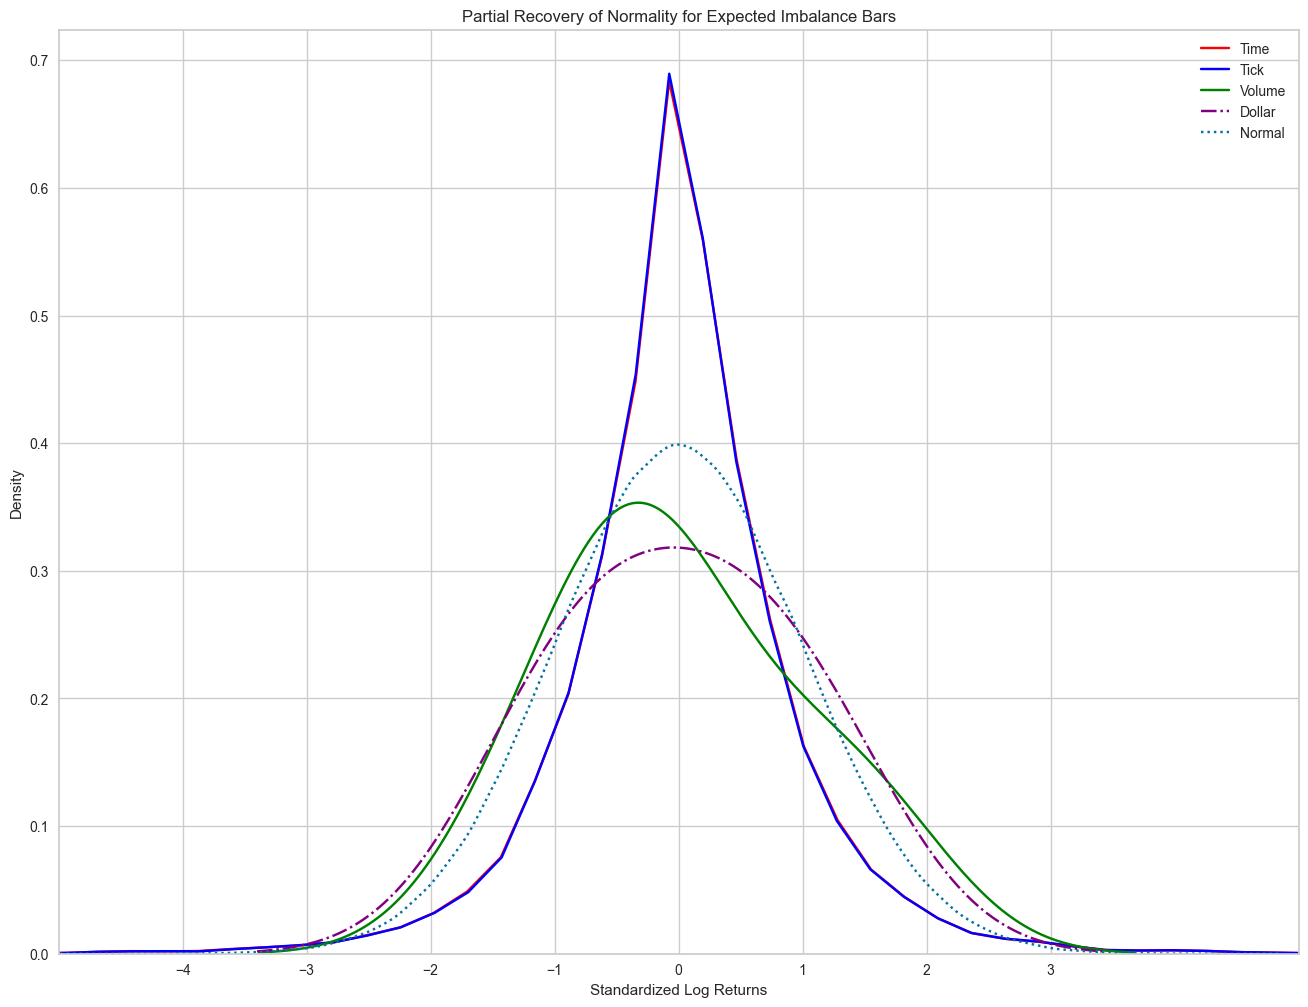

In [25]:
#Distribution Plot
plt.figure(figsize=(16, 12))
sns.kdeplot(time_standard, label="Time", color="red")
sns.kdeplot(EIB_tick_standard, label="Tick", color="blue")
sns.kdeplot(EIB_volume_standard, label="Volume", color="green")
sns.kdeplot(EIB_dollar_standard, label="Dollar", color="purple", linestyle="-.")
sns.kdeplot(np.random.normal(size=1000000), label="Normal", linestyle="dotted")
plt.xticks(range(-4, +4))

#labels
plt.xlabel("Standardized Log Returns")
plt.ylabel("Density")
plt.title(
    'Partial Recovery of Normality for Expected Imbalance Bars',
    loc='center', 
)
plt.xlim(-5, 5)
plt.legend()
plt.show()

## Run Bars

### Tick Run Bars

In [26]:
tick_run_bars = controller.handle_input_command(
    method_name="expected_tick_run_bars",
    method_arguments={
        "window_size_for_expected_n_ticks_estimation": 240, #5
        "window_size_for_expected_imbalance_estimation": 1460, #10000
        "initial_estimate_of_expected_n_ticks_in_bar": 7450, #20000
    },
    input_data=data,
    batch_size=1_000_000,
)

#Map / Aggreagate to other features

tick_run_bars_with_orderbook = attach_extra_features_to_bars(
    df,
    tick_run_bars,
    feature_cols=features,
    # optional overrides:
    # agg_spec={"spot_price": "mean"},  # if you want different aggregation
    # weighted_cols={"tr_vwap": ("tr_vwap", "tr_volume_base")},
    drop_empty=False
)

tick_run_bars_with_orderbook.head()
tick_run_bars.head()

Processing batch 0 with size 29401


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold


### Volume Run Bars

In [27]:


volume_run_bars = controller.handle_input_command(
    method_name="expected_volume_run_bars",
    method_arguments={
        "window_size_for_expected_n_ticks_estimation": 50, #5
        "window_size_for_expected_imbalance_estimation": 2000, #10000
        "initial_estimate_of_expected_n_ticks_in_bar": 200, #20000
    },
    input_data=data,
    batch_size=1_000_000,
)

#Map / Aggreagate to other features

volume_run_bars_with_orderbook = attach_extra_features_to_bars(
    df,
    volume_run_bars,
    feature_cols=features,
    # optional overrides:
    # agg_spec={"spot_price": "mean"},  # if you want different aggregation
    # weighted_cols={"tr_vwap": ("tr_vwap", "tr_volume_base")},
    drop_empty=False
)

volume_run_bars_with_orderbook.head()
volume_run_bars.head()



Processing batch 0 with size 29401


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold


### Dollar Run Bars

In [28]:
dollar_run_bars = controller.handle_input_command(
    method_name="expected_dollar_run_bars",
    method_arguments={
        "window_size_for_expected_n_ticks_estimation": 100, #5
        "window_size_for_expected_imbalance_estimation": 1000, #10000
        "initial_estimate_of_expected_n_ticks_in_bar": 500, #20000
    },
    input_data=data,
    batch_size=1_000_000,
)

#Map / Aggreagate to other features

dollar_run_bars_with_orderbook = attach_extra_features_to_bars(
    df,
    dollar_run_bars,
    feature_cols=features,
    # optional overrides:
    # agg_spec={"spot_price": "mean"},  # if you want different aggregation
    # weighted_cols={"tr_vwap": ("tr_vwap", "tr_volume_base")},
    drop_empty=False
)

dollar_run_bars_with_orderbook.head()
dollar_run_bars.head()

Processing batch 0 with size 29401


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold
0,2025-08-18 16:14:13.902734+00:00,1052,118251.351562,118316.007812,114860.632812,116105.218750,2830.342428,1022.983949,1807.358479,1052,3.307344e+08,9.568615e+07
1,2025-08-19 05:22:42.302656+00:00,1840,116085.093750,116971.796875,114574.507812,115203.500000,3217.823147,1473.979896,1743.843251,788,3.723097e+08,2.013237e+08
2,2025-08-19 21:31:16.862652+00:00,2808,115167.851562,115868.000000,112767.070312,113524.906250,4256.485605,2142.838610,2113.646996,968,4.886430e+08,2.459701e+08
3,2025-08-20 11:08:45.712661+00:00,3625,113516.007812,114016.460938,112620.218750,113738.156250,3908.332325,1918.811475,1989.520850,817,4.434084e+08,2.255656e+08
4,2025-08-20 16:03:56.502657+00:00,3920,113686.796875,114314.859375,112398.906250,113394.007812,4493.737676,2214.641060,2279.096616,295,5.098097e+08,2.572220e+08


### Statistical Test

#### Log Return

In [29]:
tick_run_bars_returns = log_return(tick_run_bars['Close'])
volume_run_bars_returns = log_return(volume_run_bars['Close'])
dollar_run_bars_returns = log_return(dollar_run_bars['Close'])

####  Jarque–Bera test statistic 

In [30]:
print("Jarque-Bera test statistic for time returns:", int(stats.jarque_bera(time_returns)[0]))
print("Jarque-Bera test statistic for tick run bars returns:", int(stats.jarque_bera(tick_run_bars_returns)[0]))
print("Jarque-Bera test statistic for volume run bars returns:", int(stats.jarque_bera(volume_run_bars_returns)[0]))
print("Jarque-Bera test statistic for dollar run bars returns:", int(stats.jarque_bera(dollar_run_bars_returns)[0]))

Jarque-Bera test statistic for time returns: 6474885


ValueError: At least one observation is required.

#### Shapiro-Wilk Test

In [ ]:
print("Shapiro-Wilk test statistic for time returns:", stats.shapiro(time_returns))
print("Shapiro-Wilk test statistic for tick run bars returns:", stats.shapiro(tick_run_bars_returns))
print("Shapiro-Wilk test statistic for volume run bars returns:", stats.shapiro(volume_run_bars_returns))
print("Shapiro-Wilk test statistic for dollar run bars returns:", stats.shapiro(dollar_run_bars_returns))

#### Kernel Density Estimate (KDE) plot

In [ ]:
#Standardize Data 
tick_run_bars_standard = (tick_run_bars_returns - tick_run_bars_returns.mean()) / tick_run_bars_returns.std()
volume_run_bars_standard = (volume_run_bars_returns  - volume_run_bars_returns.mean()) / volume_run_bars_returns.std()
dollar_run_bars_standard = (dollar_run_bars_returns - dollar_run_bars_returns.mean()) / dollar_run_bars_returns.std()

In [ ]:
#Distribution Plot
plt.figure(figsize=(16, 12))
sns.kdeplot(time_standard, label="Time", color="red")
sns.kdeplot(tick_run_bars_standard, label="Tick", color="blue")
sns.kdeplot(volume_run_bars_standard, label="Volume", color="green")
sns.kdeplot(dollar_run_bars_standard , label="Dollar", color="purple", linestyle="-.")
sns.kdeplot(np.random.normal(size=1000000), label="Normal", linestyle="dotted")
plt.xticks(range(-4, +4))

#labels
plt.xlabel("Standardized Log Returns")
plt.ylabel("Density")
plt.title(
    'Partial Recovery of Normality for Run Bars',
    loc='center', 
)
plt.xlim(-5, 5)
plt.legend()
plt.show()

# Conclustion

# Future Studies

In [31]:
Imbalance_sampling_method = ["expected_tick_imbalance_bars", "expected_volume_imbalance_bars", "expected_dollar_imbalance_bars"]
run_bars_sampling_method  = ["expected_tick_run_bars", "expected_volume_run_bars", "expected_dollar_run_bars"]

def sampling_best_params(sampling_method, df_sample, params_resampling_db, db_file_name, trials=50):

    def objective(trial):
        # Hyperparameters to tune
        param = {
            "window_size_for_expected_n_ticks_estimation": trial.suggest_int("window_size_for_expected_n_ticks_estimation", 1, 50),
            "window_size_for_expected_imbalance_estimation": trial.suggest_int("window_size_for_expected_imbalance_estimation", 100, 20000),
            "initial_estimate_of_expected_n_ticks_in_bar": trial.suggest_int("initial_estimate_of_expected_n_ticks_in_bar", 500, 20000),
            # or log-scale (Optuna ≥3 supports log for suggest_int)
            "batch_size": trial.suggest_int("batch_size", 50_000, 2_000_000, log=True)
        }

        # Generate imbalance bars
        info_driven_bar = controller.handle_input_command(
            method_name=sampling_method,
            method_arguments={
                "window_size_for_expected_n_ticks_estimation": param["window_size_for_expected_n_ticks_estimation"],
                "window_size_for_expected_imbalance_estimation": param["window_size_for_expected_imbalance_estimation"],
                "initial_estimate_of_expected_n_ticks_in_bar": param["initial_estimate_of_expected_n_ticks_in_bar"],
            },
            input_data=df_sample,
            batch_size=param["batch_size"],
        )

        # Compute returns from info_driven_bar
        info_driven_bar_returns = log_return(info_driven_bar['Close'])

        # Shapiro-Wilk test
        #minimum 3 datapoints
        # --- Guardrails for Shapiro ---
        # too few points → either prune or penalize
        if info_driven_bar_returns.size < 3:
            # Prefer pruning so Optuna doesn’t waste time on bad regions:
            raise optuna.TrialPruned("Not enough data points for Shapiro (need >= 3).")
            # or alternatively: return 1.0  # penalty

        # zero variance also breaks normality tests
        if np.allclose(np.var(info_driven_bar_returns ), 0.0):
            raise optuna.TrialPruned("Zero-variance returns.")

        # Shapiro recommended max n=5000; subsample if larger
        if info_driven_bar_returns.size > 5000:
            rng = np.random.default_rng(42)
            idx = rng.choice(info_driven_bar_returns.size, size=5000, replace=False)
            sample = info_driven_bar_returns[idx]
        else:
            sample = info_driven_bar_returns

        # --- Shapiro–Wilk test ---
        # We want "more normal" = better → maximize statistic (close to 1).
        # Optuna minimizes by default, so we return (1 - stat).
        try:
            stat, pval = stats.shapiro(sample)
        except ValueError as e:
            # e.g., numerical issues → prune this trial
            raise optuna.TrialPruned(f"Shapiro failed: {e}")

        # Store extra values for later inspection
        trial.set_user_attr("shapiro_stat", float(stat))
        trial.set_user_attr("shapiro_pval", float(pval))


        return 1.0 - float(stat)  # lower is better (stat closer to 1)
    
    def _saved_to_db (_new_params, db, file_name):
        params_resampling_db.append(_new_params)
        with open(file_name, "w") as f:
            json.dump(params_resampling_db, f, indent=4)

    # ---- preload baseline from DB, with fallback
    try:
        _db_best_params = db_resampling_best_params(_sampling_method=sampling_method, db_params=params_resampling_db)
        baseline_params = {
            "window_size_for_expected_n_ticks_estimation": int(_db_best_params["window_size_for_expected_n_ticks_estimation"]),
            "window_size_for_expected_imbalance_estimation": int(_db_best_params["window_size_for_expected_imbalance_estimation"]),
            "initial_estimate_of_expected_n_ticks_in_bar": int(_db_best_params["initial_estimate_of_expected_n_ticks_in_bar"]),
            "batch_size": int(_db_best_params["batch_size"]),
        }
    except Exception:
        # sensible midpoints as a fallback
        baseline_params = {
            "window_size_for_expected_n_ticks_estimation": 5,
            "window_size_for_expected_imbalance_estimation": 10000,
            "initial_estimate_of_expected_n_ticks_in_bar": 20000,
            "batch_size": 1_000_000,
        }

    # ---- run study
    study = optuna.create_study(direction="minimize", sampler=TPESampler(seed=42))# minimize 1 - stat
    study.enqueue_trial(baseline_params)
    study.optimize(objective, n_trials=trials)


    best = study.best_trial   # <--- define best here

    sample_size = len(df_sample)
    new_stat = best.user_attrs.get('shapiro_stat')
    new_pvalue =best.user_attrs.get('shapiro_pval')

    new_params = {  'ticker': df_sample.index.unique()[0],
                    'Sampling_Scheme': sampling_method,
                    'n_trials' : trials,
                    'n_samples': sample_size,
                    'Shapiro-Wilk_statistic': new_stat ,
                    'Shapiro-Wilk_pvalue': new_pvalue ,
                } | study.best_params 

    
    # save new param set to database if not already present
    if new_params in params_resampling_db:
        print("⚠️ Resampling parameters already exist in the database.")
    else:
        #Saved to database
        if sample_size > _db_best_params["n_samples"]:
            _saved_to_db(_new_params=new_params, db=params_resampling_db, file_name=db_file_name)
            print(
                f"✅ Saved new parameters (larger sample size: {sample_size} vs "
                f"{_db_best_params['n_samples']})."
            )
            return new_params
        #skip new paramaters
        elif sample_size < _db_best_params["n_samples"]:
            print(
                f"ℹ️  Smaller sample size ({sample_size} vs {_db_best_params['n_samples']}). "
                "Keeping existing best parameters."
            )
            return _db_best_params
        #Saved to database
        elif (
            sample_size == _db_best_params["n_samples"]
            and new_pvalue > _db_best_params["Shapiro-Wilk_pvalue"]
        ):
            _saved_to_db(_new_params=new_params, db=params_resampling_db, file_name=db_file_name)
            print(
                f"🔄 Same sample size ({sample_size}) but better p-value "
                f"({new_pvalue:.4f} vs {_db_best_params['Shapiro-Wilk_pvalue']:.4f}). "
                "Updated with new parameters."
            )
            return new_params
        #skip new paramaters
        else:
            print("ℹ️ Did not satisfy update conditions — keeping existing best parameters.")
            print("New params candidate:", new_params)
            print("Existing best params:", _db_best_params)
            return _db_best_params

In [32]:
db_best_params

{'ticker': 'BTCUSDT',
 'Sampling_Scheme': 'expected_dollar_imbalance_bars',
 'n_trials': 50,
 'n_samples': 29401,
 'Shapiro-Wilk_statistic': 0.961657166,
 'Shapiro-Wilk_pvalue': 0.832820237,
 'window_size_for_expected_n_ticks_estimation': 5,
 'window_size_for_expected_imbalance_estimation': 10000,
 'initial_estimate_of_expected_n_ticks_in_bar': 20000,
 'batch_size': 1000000}

In [33]:
x = "expected_dollar_imbalance_bars"

db_best_params = db_resampling_best_params(_sampling_method=x,db_params=db_resampling_params)
db_best_params

{'ticker': 'BTCUSDT',
 'Sampling_Scheme': 'expected_dollar_imbalance_bars',
 'n_trials': 50,
 'n_samples': 29401,
 'Shapiro-Wilk_statistic': 0.961657166,
 'Shapiro-Wilk_pvalue': 0.832820237,
 'window_size_for_expected_n_ticks_estimation': 5,
 'window_size_for_expected_imbalance_estimation': 10000,
 'initial_estimate_of_expected_n_ticks_in_bar': 20000,
 'batch_size': 1000000}

In [ ]:
y = data

x_params = sampling_best_params(sampling_method=x, df_sample=y, params_resampling_db=db_resampling_params, db_file_name=param_db_filename , trials=200)

[I 2025-09-10 19:14:48,061] A new study created in memory with name: no-name-cdacea0d-d686-4bef-bcdf-e034cca14d58
[I 2025-09-10 19:14:48,191] Trial 0 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:14:48,317] Trial 1 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 19:14:48,441] Trial 2 finished with value: 0.022551000118255615 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 3204, 'initial_estimate_of_expected_n_ticks_in_bar': 1632, 'batch_size': 1220775}. Best is trial 2 with value: 0.022551000118255615.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:14:55,494] Trial 3 finished with value: 0.25016772747039795 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_estimation': 14191, 'initial_estimate_of_expected_n_ticks_in_bar': 901, 'batch_size': 1789879}. Best is trial 2 with value: 0.022551000118255615.
[I 2025-09-10 19:14:55,618] Trial 4 finished with value: 0.15361559391021729 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 4325, 'initial_estimate_of_expected_n_ticks_in_bar': 4045, 'batch_size': 98354}. Best is trial 2 with value: 0.022551000118255615.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:14:57,270] Trial 5 finished with value: 0.6445671916007996 and parameters: {'window_size_for_expected_n_ticks_estimation': 16, 'window_size_for_expected_imbalance_estimation': 10543, 'initial_estimate_of_expected_n_ticks_in_bar': 8923, 'batch_size': 146397}. Best is trial 2 with value: 0.022551000118255615.
[I 2025-09-10 19:14:57,394] Trial 6 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:14:57,516] Trial 7 finished with value: 0.07632291316986084 and parameters: {'window_size_for_expected_n_ticks_estimation': 23, 'window_size_for_expected_imbalance_estimation': 15725, 'initial_estimate_of_expected_n_ticks_in_bar': 4393, 'batch_size': 333275}. Best is trial 2 with value: 0.022551000118255615.


Processing batch 0 with size 29401


[I 2025-09-10 19:14:57,751] Trial 8 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 19:14:57,880] Trial 9 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:14:59,065] Trial 10 finished with value: 0.6672330498695374 and parameters: {'window_size_for_expected_n_ticks_estimation': 11, 'window_size_for_expected_imbalance_estimation': 5932, 'initial_estimate_of_expected_n_ticks_in_bar': 647, 'batch_size': 53425}. Best is trial 2 with value: 0.022551000118255615.


Processing batch 0 with size 29401


[I 2025-09-10 19:15:06,319] Trial 11 finished with value: 0.15310883522033691 and parameters: {'window_size_for_expected_n_ticks_estimation': 20, 'window_size_for_expected_imbalance_estimation': 14602, 'initial_estimate_of_expected_n_ticks_in_bar': 4652, 'batch_size': 499790}. Best is trial 2 with value: 0.022551000118255615.


Processing batch 0 with size 29401


[I 2025-09-10 19:15:06,575] Trial 12 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 19:15:13,611] Trial 13 finished with value: 0.27130377292633057 and parameters: {'window_size_for_expected_n_ticks_estimation': 10, 'window_size_for_expected_imbalance_estimation': 14915, 'initial_estimate_of_expected_n_ticks_in_bar': 3052, 'batch_size': 890470}. Best is trial 2 with value: 0.022551000118255615.
[I 2025-09-10 19:15:13,749] Trial 14 finished with value: 0.14995014667510986 and parameters: {'window_size_for_expected_n_ticks_estimation': 24, 'window_size_for_expected_imbalance_estimation': 11875, 'initial_estimate_of_expected_n_ticks_in_bar': 2999, 'batch_size': 1658197}. Best is trial 2 with value: 0.022551000118255615.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:15:13,882] Trial 15 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 19:15:15,328] Trial 16 finished with value: 0.8218156695365906 and parameters: {'window_size_for_expected_n_ticks_estimation': 10, 'window_size_for_expected_imbalance_estimation': 17129, 'initial_estimate_of_expected_n_ticks_in_bar': 6241, 'batch_size': 271926}. Best is trial 2 with value: 0.022551000118255615.


Processing batch 0 with size 29401


[I 2025-09-10 19:15:20,253] Trial 17 finished with value: 0.13544368743896484 and parameters: {'window_size_for_expected_n_ticks_estimation': 26, 'window_size_for_expected_imbalance_estimation': 8359, 'initial_estimate_of_expected_n_ticks_in_bar': 578, 'batch_size': 799852}. Best is trial 2 with value: 0.022551000118255615.
[I 2025-09-10 19:15:20,385] Trial 18 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:15:28,139] Trial 19 finished with value: 0.12404096126556396 and parameters: {'window_size_for_expected_n_ticks_estimation': 14, 'window_size_for_expected_imbalance_estimation': 16753, 'initial_estimate_of_expected_n_ticks_in_bar': 2583, 'batch_size': 1282814}. Best is trial 2 with value: 0.022551000118255615.
[I 2025-09-10 19:15:28,268] Trial 20 finished with value: 0.04199981689453125 and parameters: {'window_size_for_expected_n_ticks_estimation': 37, 'window_size_for_expected_imbalance_estimation': 5855, 'initial_estimate_of_expected_n_ticks_in_bar': 5825, 'batch_size': 635386}. Best is trial 2 with value: 0.022551000118255615.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:15:28,399] Trial 21 finished with value: 0.12120842933654785 and parameters: {'window_size_for_expected_n_ticks_estimation': 37, 'window_size_for_expected_imbalance_estimation': 4688, 'initial_estimate_of_expected_n_ticks_in_bar': 6552, 'batch_size': 618779}. Best is trial 2 with value: 0.022551000118255615.


Processing batch 0 with size 29401


[I 2025-09-10 19:15:32,424] Trial 22 finished with value: 0.23541653156280518 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 7095, 'initial_estimate_of_expected_n_ticks_in_bar': 4615, 'batch_size': 353426}. Best is trial 2 with value: 0.022551000118255615.
[I 2025-09-10 19:15:32,554] Trial 23 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:15:32,686] Trial 24 finished with value: 0.01332002878189087 and parameters: {'window_size_for_expected_n_ticks_estimation': 25, 'window_size_for_expected_imbalance_estimation': 2267, 'initial_estimate_of_expected_n_ticks_in_bar': 2476, 'batch_size': 1319258}. Best is trial 24 with value: 0.01332002878189087.
[I 2025-09-10 19:15:32,819] Trial 25 finished with value: 0.2349933385848999 and parameters: {'window_size_for_expected_n_ticks_estimation': 44, 'window_size_for_expected_imbalance_estimation': 2135, 'initial_estimate_of_expected_n_ticks_in_bar': 2234, 'batch_size': 1277044}. Best is trial 24 with value: 0.01332002878189087.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:15:32,948] Trial 26 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 19:15:33,235] Trial 27 finished with value: 0.15623658895492554 and parameters: {'window_size_for_expected_n_ticks_estimation': 27, 'window_size_for_expected_imbalance_estimation': 6045, 'initial_estimate_of_expected_n_ticks_in_bar': 1902, 'batch_size': 1984983}. Best is trial 24 with value: 0.01332002878189087.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:15:33,369] Trial 28 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 19:15:33,501] Trial 29 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:15:33,635] Trial 30 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 19:15:33,766] Trial 31 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:15:34,048] Trial 32 finished with value: 0.1251542568206787 and parameters: {'window_size_for_expected_n_ticks_estimation': 17, 'window_size_for_expected_imbalance_estimation': 10077, 'initial_estimate_of_expected_n_ticks_in_bar': 5167, 'batch_size': 926504}. Best is trial 24 with value: 0.01332002878189087.
[I 2025-09-10 19:15:34,178] Trial 33 finished with value: 0.04840940237045288 and parameters: {'window_size_for_expected_n_ticks_estimation': 21, 'window_size_for_expected_imbalance_estimation': 5522, 'initial_estimate_of_expected_n_ticks_in_bar': 1631, 'batch_size': 442992}. Best is trial 24 with value: 0.01332002878189087.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:15:34,312] Trial 34 finished with value: 0.03821253776550293 and parameters: {'window_size_for_expected_n_ticks_estimation': 30, 'window_size_for_expected_imbalance_estimation': 5897, 'initial_estimate_of_expected_n_ticks_in_bar': 1617, 'batch_size': 439241}. Best is trial 24 with value: 0.01332002878189087.
[I 2025-09-10 19:15:34,443] Trial 35 finished with value: 0.08467543125152588 and parameters: {'window_size_for_expected_n_ticks_estimation': 29, 'window_size_for_expected_imbalance_estimation': 3841, 'initial_estimate_of_expected_n_ticks_in_bar': 3315, 'batch_size': 662021}. Best is trial 24 with value: 0.01332002878189087.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:15:34,577] Trial 36 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 19:15:38,561] Trial 37 finished with value: 0.1293201446533203 and parameters: {'window_size_for_expected_n_ticks_estimation': 33, 'window_size_for_expected_imbalance_estimation': 7438, 'initial_estimate_of_expected_n_ticks_in_bar': 1259, 'batch_size': 529117}. Best is trial 24 with value: 0.01332002878189087.


Processing batch 0 with size 29401


[I 2025-09-10 19:15:38,792] Trial 38 finished with value: 0.1069493293762207 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 6534, 'initial_estimate_of_expected_n_ticks_in_bar': 3692, 'batch_size': 1609533}. Best is trial 24 with value: 0.01332002878189087.
[I 2025-09-10 19:15:38,923] Trial 39 finished with value: 0.14387333393096924 and parameters: {'window_size_for_expected_n_ticks_estimation': 39, 'window_size_for_expected_imbalance_estimation': 4879, 'initial_estimate_of_expected_n_ticks_in_bar': 5528, 'batch_size': 864969}. Best is trial 24 with value: 0.01332002878189087.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:15:39,054] Trial 40 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 19:15:39,184] Trial 41 finished with value: 0.02515876293182373 and parameters: {'window_size_for_expected_n_ticks_estimation': 14, 'window_size_for_expected_imbalance_estimation': 5198, 'initial_estimate_of_expected_n_ticks_in_bar': 1476, 'batch_size': 428743}. Best is trial 24 with value: 0.01332002878189087.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:15:39,314] Trial 42 finished with value: 0.08179330825805664 and parameters: {'window_size_for_expected_n_ticks_estimation': 7, 'window_size_for_expected_imbalance_estimation': 3997, 'initial_estimate_of_expected_n_ticks_in_bar': 1421, 'batch_size': 379266}. Best is trial 24 with value: 0.01332002878189087.


Processing batch 0 with size 29401


[I 2025-09-10 19:15:44,273] Trial 43 finished with value: 0.23756372928619385 and parameters: {'window_size_for_expected_n_ticks_estimation': 13, 'window_size_for_expected_imbalance_estimation': 8922, 'initial_estimate_of_expected_n_ticks_in_bar': 692, 'batch_size': 444457}. Best is trial 24 with value: 0.01332002878189087.
[I 2025-09-10 19:15:44,401] Trial 44 finished with value: 0.06421059370040894 and parameters: {'window_size_for_expected_n_ticks_estimation': 17, 'window_size_for_expected_imbalance_estimation': 1384, 'initial_estimate_of_expected_n_ticks_in_bar': 2622, 'batch_size': 152135}. Best is trial 24 with value: 0.01332002878189087.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:15:45,129] Trial 45 finished with value: 0.5191008448600769 and parameters: {'window_size_for_expected_n_ticks_estimation': 1, 'window_size_for_expected_imbalance_estimation': 5416, 'initial_estimate_of_expected_n_ticks_in_bar': 3906, 'batch_size': 297822}. Best is trial 24 with value: 0.01332002878189087.


Processing batch 0 with size 29401


[I 2025-09-10 19:15:48,558] Trial 46 finished with value: 0.24862706661224365 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 6490, 'initial_estimate_of_expected_n_ticks_in_bar': 2784, 'batch_size': 535197}. Best is trial 24 with value: 0.01332002878189087.


Processing batch 0 with size 29401


[I 2025-09-10 19:15:54,437] Trial 47 finished with value: 0.12937724590301514 and parameters: {'window_size_for_expected_n_ticks_estimation': 32, 'window_size_for_expected_imbalance_estimation': 11195, 'initial_estimate_of_expected_n_ticks_in_bar': 1352, 'batch_size': 736918}. Best is trial 24 with value: 0.01332002878189087.


Processing batch 0 with size 29401


[I 2025-09-10 19:15:56,000] Trial 48 finished with value: 0.13746511936187744 and parameters: {'window_size_for_expected_n_ticks_estimation': 4, 'window_size_for_expected_imbalance_estimation': 2640, 'initial_estimate_of_expected_n_ticks_in_bar': 4810, 'batch_size': 611617}. Best is trial 24 with value: 0.01332002878189087.
[I 2025-09-10 19:15:56,133] Trial 49 finished with value: 0.05133175849914551 and parameters: {'window_size_for_expected_n_ticks_estimation': 14, 'window_size_for_expected_imbalance_estimation': 4085, 'initial_estimate_of_expected_n_ticks_in_bar': 3407, 'batch_size': 1036824}. Best is trial 24 with value: 0.01332002878189087.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:15:56,269] Trial 50 finished with value: 0.18542295694351196 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_estimation': 7920, 'initial_estimate_of_expected_n_ticks_in_bar': 6616, 'batch_size': 52801}. Best is trial 24 with value: 0.01332002878189087.


Processing batch 0 with size 29401


[I 2025-09-10 19:15:59,550] Trial 51 finished with value: 0.12337368726730347 and parameters: {'window_size_for_expected_n_ticks_estimation': 24, 'window_size_for_expected_imbalance_estimation': 5444, 'initial_estimate_of_expected_n_ticks_in_bar': 1667, 'batch_size': 470771}. Best is trial 24 with value: 0.01332002878189087.


Processing batch 0 with size 29401


[I 2025-09-10 19:15:59,815] Trial 52 finished with value: 0.027819037437438965 and parameters: {'window_size_for_expected_n_ticks_estimation': 22, 'window_size_for_expected_imbalance_estimation': 5383, 'initial_estimate_of_expected_n_ticks_in_bar': 2175, 'batch_size': 436429}. Best is trial 24 with value: 0.01332002878189087.


Processing batch 0 with size 29401


[I 2025-09-10 19:16:03,480] Trial 53 finished with value: 0.13340437412261963 and parameters: {'window_size_for_expected_n_ticks_estimation': 11, 'window_size_for_expected_imbalance_estimation': 6939, 'initial_estimate_of_expected_n_ticks_in_bar': 2603, 'batch_size': 261454}. Best is trial 24 with value: 0.01332002878189087.
[I 2025-09-10 19:16:03,613] Trial 54 finished with value: 0.0704801082611084 and parameters: {'window_size_for_expected_n_ticks_estimation': 22, 'window_size_for_expected_imbalance_estimation': 3437, 'initial_estimate_of_expected_n_ticks_in_bar': 701, 'batch_size': 337251}. Best is trial 24 with value: 0.01332002878189087.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:03,748] Trial 55 finished with value: 0.06382113695144653 and parameters: {'window_size_for_expected_n_ticks_estimation': 25, 'window_size_for_expected_imbalance_estimation': 4573, 'initial_estimate_of_expected_n_ticks_in_bar': 4242, 'batch_size': 393193}. Best is trial 24 with value: 0.01332002878189087.
[I 2025-09-10 19:16:03,884] Trial 56 finished with value: 0.1460500955581665 and parameters: {'window_size_for_expected_n_ticks_estimation': 19, 'window_size_for_expected_imbalance_estimation': 1097, 'initial_estimate_of_expected_n_ticks_in_bar': 524, 'batch_size': 564505}. Best is trial 24 with value: 0.01332002878189087.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:04,023] Trial 57 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 19:16:08,452] Trial 58 finished with value: 0.2971576452255249 and parameters: {'window_size_for_expected_n_ticks_estimation': 18, 'window_size_for_expected_imbalance_estimation': 8099, 'initial_estimate_of_expected_n_ticks_in_bar': 3191, 'batch_size': 1787844}. Best is trial 24 with value: 0.01332002878189087.
[I 2025-09-10 19:16:08,583] Trial 59 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:08,717] Trial 60 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 19:16:08,850] Trial 61 finished with value: 0.04344761371612549 and parameters: {'window_size_for_expected_n_ticks_estimation': 22, 'window_size_for_expected_imbalance_estimation': 5092, 'initial_estimate_of_expected_n_ticks_in_bar': 1548, 'batch_size': 436345}. Best is trial 24 with value: 0.01332002878189087.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:08,982] Trial 62 finished with value: 0.04827314615249634 and parameters: {'window_size_for_expected_n_ticks_estimation': 24, 'window_size_for_expected_imbalance_estimation': 5145, 'initial_estimate_of_expected_n_ticks_in_bar': 1200, 'batch_size': 316335}. Best is trial 24 with value: 0.01332002878189087.


Processing batch 0 with size 29401


[I 2025-09-10 19:16:09,232] Trial 63 finished with value: 0.024701833724975586 and parameters: {'window_size_for_expected_n_ticks_estimation': 36, 'window_size_for_expected_imbalance_estimation': 5942, 'initial_estimate_of_expected_n_ticks_in_bar': 1914, 'batch_size': 476269}. Best is trial 24 with value: 0.01332002878189087.


Processing batch 0 with size 29401


[I 2025-09-10 19:16:13,250] Trial 64 finished with value: 0.11379671096801758 and parameters: {'window_size_for_expected_n_ticks_estimation': 37, 'window_size_for_expected_imbalance_estimation': 7168, 'initial_estimate_of_expected_n_ticks_in_bar': 2427, 'batch_size': 588570}. Best is trial 24 with value: 0.01332002878189087.


Processing batch 0 with size 29401


[I 2025-09-10 19:16:21,856] Trial 65 finished with value: 0.24722295999526978 and parameters: {'window_size_for_expected_n_ticks_estimation': 40, 'window_size_for_expected_imbalance_estimation': 19840, 'initial_estimate_of_expected_n_ticks_in_bar': 4249, 'batch_size': 493325}. Best is trial 24 with value: 0.01332002878189087.


Processing batch 0 with size 29401


[I 2025-09-10 19:16:26,665] Trial 66 finished with value: 0.12101542949676514 and parameters: {'window_size_for_expected_n_ticks_estimation': 35, 'window_size_for_expected_imbalance_estimation': 8562, 'initial_estimate_of_expected_n_ticks_in_bar': 2157, 'batch_size': 1186097}. Best is trial 24 with value: 0.01332002878189087.
[I 2025-09-10 19:16:26,798] Trial 67 finished with value: 0.08097010850906372 and parameters: {'window_size_for_expected_n_ticks_estimation': 9, 'window_size_for_expected_imbalance_estimation': 4088, 'initial_estimate_of_expected_n_ticks_in_bar': 3198, 'batch_size': 710390}. Best is trial 24 with value: 0.01332002878189087.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:26,934] Trial 68 finished with value: 0.18379747867584229 and parameters: {'window_size_for_expected_n_ticks_estimation': 45, 'window_size_for_expected_imbalance_estimation': 9572, 'initial_estimate_of_expected_n_ticks_in_bar': 4987, 'batch_size': 828028}. Best is trial 24 with value: 0.01332002878189087.
[I 2025-09-10 19:16:27,067] Trial 69 finished with value: 0.03722846508026123 and parameters: {'window_size_for_expected_n_ticks_estimation': 32, 'window_size_for_expected_imbalance_estimation': 5935, 'initial_estimate_of_expected_n_ticks_in_bar': 1028, 'batch_size': 368924}. Best is trial 24 with value: 0.01332002878189087.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:33,523] Trial 70 finished with value: 0.13058292865753174 and parameters: {'window_size_for_expected_n_ticks_estimation': 30, 'window_size_for_expected_imbalance_estimation': 12844, 'initial_estimate_of_expected_n_ticks_in_bar': 1171, 'batch_size': 155604}. Best is trial 24 with value: 0.01332002878189087.


Processing batch 0 with size 29401


[I 2025-09-10 19:16:33,769] Trial 71 finished with value: 0.06032824516296387 and parameters: {'window_size_for_expected_n_ticks_estimation': 37, 'window_size_for_expected_imbalance_estimation': 6112, 'initial_estimate_of_expected_n_ticks_in_bar': 9600, 'batch_size': 360373}. Best is trial 24 with value: 0.01332002878189087.
[I 2025-09-10 19:16:33,904] Trial 72 finished with value: 0.0995175838470459 and parameters: {'window_size_for_expected_n_ticks_estimation': 32, 'window_size_for_expected_imbalance_estimation': 6710, 'initial_estimate_of_expected_n_ticks_in_bar': 2062, 'batch_size': 397792}. Best is trial 24 with value: 0.01332002878189087.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:34,041] Trial 73 finished with value: 0.05976831912994385 and parameters: {'window_size_for_expected_n_ticks_estimation': 27, 'window_size_for_expected_imbalance_estimation': 5724, 'initial_estimate_of_expected_n_ticks_in_bar': 934, 'batch_size': 289735}. Best is trial 24 with value: 0.01332002878189087.
[I 2025-09-10 19:16:34,177] Trial 74 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:34,314] Trial 75 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 19:16:34,447] Trial 76 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:34,723] Trial 77 finished with value: 0.041357219219207764 and parameters: {'window_size_for_expected_n_ticks_estimation': 33, 'window_size_for_expected_imbalance_estimation': 4695, 'initial_estimate_of_expected_n_ticks_in_bar': 1838, 'batch_size': 344936}. Best is trial 24 with value: 0.01332002878189087.
[I 2025-09-10 19:16:34,856] Trial 78 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:37,124] Trial 79 finished with value: 0.08698338270187378 and parameters: {'window_size_for_expected_n_ticks_estimation': 28, 'window_size_for_expected_imbalance_estimation': 3671, 'initial_estimate_of_expected_n_ticks_in_bar': 566, 'batch_size': 260050}. Best is trial 24 with value: 0.01332002878189087.
[I 2025-09-10 19:16:37,259] Trial 80 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:37,396] Trial 81 finished with value: 0.048266828060150146 and parameters: {'window_size_for_expected_n_ticks_estimation': 35, 'window_size_for_expected_imbalance_estimation': 4550, 'initial_estimate_of_expected_n_ticks_in_bar': 2738, 'batch_size': 365325}. Best is trial 24 with value: 0.01332002878189087.


Processing batch 0 with size 29401


[I 2025-09-10 19:16:41,565] Trial 82 finished with value: 0.13763999938964844 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_estimation': 7510, 'initial_estimate_of_expected_n_ticks_in_bar': 1039, 'batch_size': 930985}. Best is trial 24 with value: 0.01332002878189087.
[I 2025-09-10 19:16:41,701] Trial 83 finished with value: 0.09356200695037842 and parameters: {'window_size_for_expected_n_ticks_estimation': 4, 'window_size_for_expected_imbalance_estimation': 6307, 'initial_estimate_of_expected_n_ticks_in_bar': 3570, 'batch_size': 1426669}. Best is trial 24 with value: 0.01332002878189087.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:41,837] Trial 84 finished with value: 0.03215724229812622 and parameters: {'window_size_for_expected_n_ticks_estimation': 41, 'window_size_for_expected_imbalance_estimation': 5598, 'initial_estimate_of_expected_n_ticks_in_bar': 1536, 'batch_size': 512511}. Best is trial 24 with value: 0.01332002878189087.
[I 2025-09-10 19:16:41,975] Trial 85 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:42,111] Trial 86 finished with value: 0.018662691116333008 and parameters: {'window_size_for_expected_n_ticks_estimation': 41, 'window_size_for_expected_imbalance_estimation': 2988, 'initial_estimate_of_expected_n_ticks_in_bar': 1629, 'batch_size': 443615}. Best is trial 24 with value: 0.01332002878189087.


Processing batch 0 with size 29401


[I 2025-09-10 19:16:42,376] Trial 87 finished with value: 0.029122471809387207 and parameters: {'window_size_for_expected_n_ticks_estimation': 41, 'window_size_for_expected_imbalance_estimation': 3131, 'initial_estimate_of_expected_n_ticks_in_bar': 2379, 'batch_size': 455412}. Best is trial 24 with value: 0.01332002878189087.
[I 2025-09-10 19:16:42,511] Trial 88 finished with value: 0.0019972920417785645 and parameters: {'window_size_for_expected_n_ticks_estimation': 44, 'window_size_for_expected_imbalance_estimation': 2971, 'initial_estimate_of_expected_n_ticks_in_bar': 2433, 'batch_size': 1998023}. Best is trial 88 with value: 0.0019972920417785645.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:42,650] Trial 89 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 19:16:42,792] Trial 90 finished with value: 0.09630513191223145 and parameters: {'window_size_for_expected_n_ticks_estimation': 41, 'window_size_for_expected_imbalance_estimation': 2062, 'initial_estimate_of_expected_n_ticks_in_bar': 2384, 'batch_size': 1603552}. Best is trial 88 with value: 0.0019972920417785645.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:42,929] Trial 91 finished with value: 0.17828702926635742 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 2786, 'initial_estimate_of_expected_n_ticks_in_bar': 1138, 'batch_size': 1752846}. Best is trial 88 with value: 0.0019972920417785645.
[I 2025-09-10 19:16:43,065] Trial 92 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:44,059] Trial 93 finished with value: 0.11402416229248047 and parameters: {'window_size_for_expected_n_ticks_estimation': 43, 'window_size_for_expected_imbalance_estimation': 1055, 'initial_estimate_of_expected_n_ticks_in_bar': 2397, 'batch_size': 419587}. Best is trial 88 with value: 0.0019972920417785645.
[I 2025-09-10 19:16:44,194] Trial 94 finished with value: 0.008155882358551025 and parameters: {'window_size_for_expected_n_ticks_estimation': 38, 'window_size_for_expected_imbalance_estimation': 1705, 'initial_estimate_of_expected_n_ticks_in_bar': 1462, 'batch_size': 469720}. Best is trial 88 with value: 0.0019972920417785645.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:44,331] Trial 95 finished with value: 0.2004123330116272 and parameters: {'window_size_for_expected_n_ticks_estimation': 41, 'window_size_for_expected_imbalance_estimation': 1678, 'initial_estimate_of_expected_n_ticks_in_bar': 1592, 'batch_size': 519208}. Best is trial 88 with value: 0.0019972920417785645.
[I 2025-09-10 19:16:44,468] Trial 96 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:44,759] Trial 97 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 19:16:44,898] Trial 98 finished with value: 0.004396021366119385 and parameters: {'window_size_for_expected_n_ticks_estimation': 41, 'window_size_for_expected_imbalance_estimation': 2366, 'initial_estimate_of_expected_n_ticks_in_bar': 2585, 'batch_size': 774131}. Best is trial 88 with value: 0.0019972920417785645.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:45,038] Trial 99 finished with value: 0.00037044286727905273 and parameters: {'window_size_for_expected_n_ticks_estimation': 43, 'window_size_for_expected_imbalance_estimation': 2428, 'initial_estimate_of_expected_n_ticks_in_bar': 2799, 'batch_size': 783547}. Best is trial 99 with value: 0.00037044286727905273.
[I 2025-09-10 19:16:45,176] Trial 100 finished with value: 0.0009940862655639648 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 2630, 'initial_estimate_of_expected_n_ticks_in_bar': 3015, 'batch_size': 1072688}. Best is trial 99 with value: 0.00037044286727905273.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:45,311] Trial 101 finished with value: 0.0005308389663696289 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 2497, 'initial_estimate_of_expected_n_ticks_in_bar': 2764, 'batch_size': 767487}. Best is trial 99 with value: 0.00037044286727905273.
[I 2025-09-10 19:16:45,447] Trial 102 finished with value: 0.0032536983489990234 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 2290, 'initial_estimate_of_expected_n_ticks_in_bar': 2755, 'batch_size': 976098}. Best is trial 99 with value: 0.00037044286727905273.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:45,717] Trial 103 finished with value: 0.0003261566162109375 and parameters: {'window_size_for_expected_n_ticks_estimation': 49, 'window_size_for_expected_imbalance_estimation': 2166, 'initial_estimate_of_expected_n_ticks_in_bar': 2837, 'batch_size': 1095979}. Best is trial 103 with value: 0.0003261566162109375.
[I 2025-09-10 19:16:45,854] Trial 104 finished with value: 0.0039939284324646 and parameters: {'window_size_for_expected_n_ticks_estimation': 49, 'window_size_for_expected_imbalance_estimation': 2434, 'initial_estimate_of_expected_n_ticks_in_bar': 3193, 'batch_size': 1103701}. Best is trial 103 with value: 0.0003261566162109375.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:45,994] Trial 105 finished with value: 0.11916029453277588 and parameters: {'window_size_for_expected_n_ticks_estimation': 49, 'window_size_for_expected_imbalance_estimation': 2440, 'initial_estimate_of_expected_n_ticks_in_bar': 4092, 'batch_size': 1081014}. Best is trial 103 with value: 0.0003261566162109375.
[I 2025-09-10 19:16:46,133] Trial 106 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:46,271] Trial 107 finished with value: 0.050042569637298584 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 1940, 'initial_estimate_of_expected_n_ticks_in_bar': 3344, 'batch_size': 931646}. Best is trial 103 with value: 0.0003261566162109375.
[I 2025-09-10 19:16:46,411] Trial 108 finished with value: 0.02265310287475586 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 2473, 'initial_estimate_of_expected_n_ticks_in_bar': 4779, 'batch_size': 771435}. Best is trial 103 with value: 0.0003261566162109375.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:46,662] Trial 109 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 19:16:46,799] Trial 110 finished with value: 0.06591582298278809 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 1601, 'initial_estimate_of_expected_n_ticks_in_bar': 5207, 'batch_size': 979400}. Best is trial 103 with value: 0.0003261566162109375.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:46,940] Trial 111 finished with value: 8.362531661987305e-05 and parameters: {'window_size_for_expected_n_ticks_estimation': 43, 'window_size_for_expected_imbalance_estimation': 2671, 'initial_estimate_of_expected_n_ticks_in_bar': 2765, 'batch_size': 1301138}. Best is trial 111 with value: 8.362531661987305e-05.
[I 2025-09-10 19:16:47,077] Trial 112 finished with value: 0.005504310131072998 and parameters: {'window_size_for_expected_n_ticks_estimation': 43, 'window_size_for_expected_imbalance_estimation': 2616, 'initial_estimate_of_expected_n_ticks_in_bar': 2645, 'batch_size': 866463}. Best is trial 111 with value: 8.362531661987305e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:47,215] Trial 113 finished with value: 0.004177272319793701 and parameters: {'window_size_for_expected_n_ticks_estimation': 43, 'window_size_for_expected_imbalance_estimation': 2396, 'initial_estimate_of_expected_n_ticks_in_bar': 3521, 'batch_size': 850297}. Best is trial 111 with value: 8.362531661987305e-05.
[I 2025-09-10 19:16:47,354] Trial 114 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:47,624] Trial 115 finished with value: 0.16137707233428955 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 1968, 'initial_estimate_of_expected_n_ticks_in_bar': 3282, 'batch_size': 990840}. Best is trial 111 with value: 8.362531661987305e-05.
[I 2025-09-10 19:16:47,762] Trial 116 finished with value: 0.01899862289428711 and parameters: {'window_size_for_expected_n_ticks_estimation': 44, 'window_size_for_expected_imbalance_estimation': 1277, 'initial_estimate_of_expected_n_ticks_in_bar': 4091, 'batch_size': 735812}. Best is trial 111 with value: 8.362531661987305e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:47,898] Trial 117 finished with value: 0.07774782180786133 and parameters: {'window_size_for_expected_n_ticks_estimation': 49, 'window_size_for_expected_imbalance_estimation': 2370, 'initial_estimate_of_expected_n_ticks_in_bar': 4483, 'batch_size': 889925}. Best is trial 111 with value: 8.362531661987305e-05.
[I 2025-09-10 19:16:48,037] Trial 118 finished with value: 0.0001963973045349121 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 3368, 'initial_estimate_of_expected_n_ticks_in_bar': 2744, 'batch_size': 1257459}. Best is trial 111 with value: 8.362531661987305e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:48,179] Trial 119 finished with value: 1.329183578491211e-05 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 3488, 'initial_estimate_of_expected_n_ticks_in_bar': 2712, 'batch_size': 1213869}. Best is trial 119 with value: 1.329183578491211e-05.


Processing batch 0 with size 29401


[I 2025-09-10 19:16:48,455] Trial 120 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 19:16:48,593] Trial 121 finished with value: 0.056092023849487305 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 3344, 'initial_estimate_of_expected_n_ticks_in_bar': 3632, 'batch_size': 1260961}. Best is trial 119 with value: 1.329183578491211e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:48,732] Trial 122 finished with value: 0.06857240200042725 and parameters: {'window_size_for_expected_n_ticks_estimation': 43, 'window_size_for_expected_imbalance_estimation': 4018, 'initial_estimate_of_expected_n_ticks_in_bar': 2616, 'batch_size': 1024197}. Best is trial 119 with value: 1.329183578491211e-05.
[I 2025-09-10 19:16:48,870] Trial 123 finished with value: 0.0005561113357543945 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 2793, 'initial_estimate_of_expected_n_ticks_in_bar': 3306, 'batch_size': 1409974}. Best is trial 119 with value: 1.329183578491211e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:49,010] Trial 124 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 19:16:49,147] Trial 125 finished with value: 0.052097856998443604 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 2900, 'initial_estimate_of_expected_n_ticks_in_bar': 4103, 'batch_size': 1515023}. Best is trial 119 with value: 1.329183578491211e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:49,427] Trial 126 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 19:16:49,565] Trial 127 finished with value: 3.319978713989258e-05 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 3236, 'initial_estimate_of_expected_n_ticks_in_bar': 3089, 'batch_size': 798516}. Best is trial 119 with value: 1.329183578491211e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:49,705] Trial 128 finished with value: 0.05185633897781372 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 4290, 'initial_estimate_of_expected_n_ticks_in_bar': 3161, 'batch_size': 1381258}. Best is trial 119 with value: 1.329183578491211e-05.
[I 2025-09-10 19:16:49,848] Trial 129 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:49,987] Trial 130 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 19:16:50,129] Trial 131 finished with value: 5.835294723510742e-05 and parameters: {'window_size_for_expected_n_ticks_estimation': 45, 'window_size_for_expected_imbalance_estimation': 1832, 'initial_estimate_of_expected_n_ticks_in_bar': 2932, 'batch_size': 782088}. Best is trial 119 with value: 1.329183578491211e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:50,402] Trial 132 finished with value: 0.001098930835723877 and parameters: {'window_size_for_expected_n_ticks_estimation': 45, 'window_size_for_expected_imbalance_estimation': 1850, 'initial_estimate_of_expected_n_ticks_in_bar': 2916, 'batch_size': 688247}. Best is trial 119 with value: 1.329183578491211e-05.
[I 2025-09-10 19:16:50,541] Trial 133 finished with value: 0.019529759883880615 and parameters: {'window_size_for_expected_n_ticks_estimation': 45, 'window_size_for_expected_imbalance_estimation': 1448, 'initial_estimate_of_expected_n_ticks_in_bar': 3054, 'batch_size': 1059708}. Best is trial 119 with value: 1.329183578491211e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:50,685] Trial 134 finished with value: 0.05108022689819336 and parameters: {'window_size_for_expected_n_ticks_estimation': 49, 'window_size_for_expected_imbalance_estimation': 1790, 'initial_estimate_of_expected_n_ticks_in_bar': 2177, 'batch_size': 704951}. Best is trial 119 with value: 1.329183578491211e-05.
[I 2025-09-10 19:16:50,826] Trial 135 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:50,963] Trial 136 finished with value: 0.00024437904357910156 and parameters: {'window_size_for_expected_n_ticks_estimation': 45, 'window_size_for_expected_imbalance_estimation': 2824, 'initial_estimate_of_expected_n_ticks_in_bar': 2692, 'batch_size': 1154172}. Best is trial 119 with value: 1.329183578491211e-05.
[I 2025-09-10 19:16:51,101] Trial 137 finished with value: 0.010396063327789307 and parameters: {'window_size_for_expected_n_ticks_estimation': 45, 'window_size_for_expected_imbalance_estimation': 2792, 'initial_estimate_of_expected_n_ticks_in_bar': 2472, 'batch_size': 656179}. Best is trial 119 with value: 1.329183578491211e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:51,345] Trial 138 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 19:16:51,484] Trial 139 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:51,622] Trial 140 finished with value: 0.06884479522705078 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 1853, 'initial_estimate_of_expected_n_ticks_in_bar': 4424, 'batch_size': 1893049}. Best is trial 119 with value: 1.329183578491211e-05.
[I 2025-09-10 19:16:51,761] Trial 141 finished with value: 3.1888484954833984e-05 and parameters: {'window_size_for_expected_n_ticks_estimation': 50, 'window_size_for_expected_imbalance_estimation': 2730, 'initial_estimate_of_expected_n_ticks_in_bar': 2757, 'batch_size': 1179192}. Best is trial 119 with value: 1.329183578491211e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:16:59,904] Trial 142 finished with value: 0.1268174648284912 and parameters: {'window_size_for_expected_n_ticks_estimation': 50, 'window_size_for_expected_imbalance_estimation': 17794, 'initial_estimate_of_expected_n_ticks_in_bar': 2729, 'batch_size': 1213887}. Best is trial 119 with value: 1.329183578491211e-05.
[I 2025-09-10 19:17:00,042] Trial 143 finished with value: 0.0989452600479126 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 2974, 'initial_estimate_of_expected_n_ticks_in_bar': 2227, 'batch_size': 912460}. Best is trial 119 with value: 1.329183578491211e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:17:00,315] Trial 144 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 19:17:00,455] Trial 145 finished with value: 0.05347341299057007 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 1193, 'initial_estimate_of_expected_n_ticks_in_bar': 2778, 'batch_size': 1184317}. Best is trial 119 with value: 1.329183578491211e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:17:00,596] Trial 146 finished with value: 0.07139557600021362 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 2133, 'initial_estimate_of_expected_n_ticks_in_bar': 3535, 'batch_size': 996981}. Best is trial 119 with value: 1.329183578491211e-05.
[I 2025-09-10 19:17:00,736] Trial 147 finished with value: 0.0042684078216552734 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 3433, 'initial_estimate_of_expected_n_ticks_in_bar': 2438, 'batch_size': 1343578}. Best is trial 119 with value: 1.329183578491211e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:17:00,873] Trial 148 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 19:17:01,015] Trial 149 finished with value: 0.0005493760108947754 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 2773, 'initial_estimate_of_expected_n_ticks_in_bar': 3286, 'batch_size': 1078117}. Best is trial 119 with value: 1.329183578491211e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:17:01,270] Trial 150 finished with value: 0.00173872709274292 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 2939, 'initial_estimate_of_expected_n_ticks_in_bar': 3329, 'batch_size': 1150316}. Best is trial 119 with value: 1.329183578491211e-05.
[I 2025-09-10 19:17:01,412] Trial 151 finished with value: 6.079673767089844e-06 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 2903, 'initial_estimate_of_expected_n_ticks_in_bar': 3302, 'batch_size': 1154723}. Best is trial 151 with value: 6.079673767089844e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:17:01,553] Trial 152 finished with value: 0.08644092082977295 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 2776, 'initial_estimate_of_expected_n_ticks_in_bar': 3349, 'batch_size': 1162806}. Best is trial 151 with value: 6.079673767089844e-06.
[I 2025-09-10 19:17:01,692] Trial 153 finished with value: 0.06527018547058105 and parameters: {'window_size_for_expected_n_ticks_estimation': 44, 'window_size_for_expected_imbalance_estimation': 3319, 'initial_estimate_of_expected_n_ticks_in_bar': 4069, 'batch_size': 1135340}. Best is trial 151 with value: 6.079673767089844e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:17:01,834] Trial 154 finished with value: 0.0002669692039489746 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 2643, 'initial_estimate_of_expected_n_ticks_in_bar': 3206, 'batch_size': 1037800}. Best is trial 151 with value: 6.079673767089844e-06.


Processing batch 0 with size 29401


[I 2025-09-10 19:17:02,084] Trial 155 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 19:17:02,224] Trial 156 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:17:09,705] Trial 157 finished with value: 0.1461493968963623 and parameters: {'window_size_for_expected_n_ticks_estimation': 45, 'window_size_for_expected_imbalance_estimation': 15545, 'initial_estimate_of_expected_n_ticks_in_bar': 4756, 'batch_size': 1404481}. Best is trial 151 with value: 6.079673767089844e-06.
[I 2025-09-10 19:17:09,844] Trial 158 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:17:09,985] Trial 159 finished with value: 0.09327399730682373 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 3673, 'initial_estimate_of_expected_n_ticks_in_bar': 4371, 'batch_size': 1075382}. Best is trial 151 with value: 6.079673767089844e-06.


Processing batch 0 with size 29401


[I 2025-09-10 19:17:10,264] Trial 160 finished with value: 0.018762171268463135 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 2058, 'initial_estimate_of_expected_n_ticks_in_bar': 3222, 'batch_size': 674332}. Best is trial 151 with value: 6.079673767089844e-06.
[I 2025-09-10 19:17:10,410] Trial 161 finished with value: 0.053063273429870605 and parameters: {'window_size_for_expected_n_ticks_estimation': 43, 'window_size_for_expected_imbalance_estimation': 2763, 'initial_estimate_of_expected_n_ticks_in_bar': 3312, 'batch_size': 1205099}. Best is trial 151 with value: 6.079673767089844e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:17:10,553] Trial 162 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 19:17:10,694] Trial 163 finished with value: 0.0010831356048583984 and parameters: {'window_size_for_expected_n_ticks_estimation': 40, 'window_size_for_expected_imbalance_estimation': 2679, 'initial_estimate_of_expected_n_ticks_in_bar': 3561, 'batch_size': 894182}. Best is trial 151 with value: 6.079673767089844e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:17:10,837] Trial 164 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 19:17:10,978] Trial 165 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:17:11,273] Trial 166 finished with value: 9.948015213012695e-05 and parameters: {'window_size_for_expected_n_ticks_estimation': 40, 'window_size_for_expected_imbalance_estimation': 2257, 'initial_estimate_of_expected_n_ticks_in_bar': 2649, 'batch_size': 1032410}. Best is trial 151 with value: 6.079673767089844e-06.
[I 2025-09-10 19:17:11,414] Trial 167 finished with value: 0.0812995433807373 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 3860, 'initial_estimate_of_expected_n_ticks_in_bar': 2596, 'batch_size': 1065343}. Best is trial 151 with value: 6.079673767089844e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:17:11,555] Trial 168 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 19:17:11,696] Trial 169 finished with value: 0.14958590269088745 and parameters: {'window_size_for_expected_n_ticks_estimation': 49, 'window_size_for_expected_imbalance_estimation': 3495, 'initial_estimate_of_expected_n_ticks_in_bar': 3505, 'batch_size': 1026378}. Best is trial 151 with value: 6.079673767089844e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:17:11,838] Trial 170 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 19:17:11,980] Trial 171 finished with value: 0.052301764488220215 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 1633, 'initial_estimate_of_expected_n_ticks_in_bar': 2923, 'batch_size': 871615}. Best is trial 151 with value: 6.079673767089844e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:17:12,239] Trial 172 finished with value: 0.019605517387390137 and parameters: {'window_size_for_expected_n_ticks_estimation': 44, 'window_size_for_expected_imbalance_estimation': 2133, 'initial_estimate_of_expected_n_ticks_in_bar': 2556, 'batch_size': 776065}. Best is trial 151 with value: 6.079673767089844e-06.
[I 2025-09-10 19:17:12,378] Trial 173 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:17:12,520] Trial 174 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 19:17:12,664] Trial 175 finished with value: 0.0532984733581543 and parameters: {'window_size_for_expected_n_ticks_estimation': 44, 'window_size_for_expected_imbalance_estimation': 2040, 'initial_estimate_of_expected_n_ticks_in_bar': 4112, 'batch_size': 1369342}. Best is trial 151 with value: 6.079673767089844e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:17:12,807] Trial 176 finished with value: 0.05955630540847778 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 1395, 'initial_estimate_of_expected_n_ticks_in_bar': 3163, 'batch_size': 968342}. Best is trial 151 with value: 6.079673767089844e-06.
[I 2025-09-10 19:17:12,945] Trial 177 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:17:13,234] Trial 178 finished with value: 0.0004024505615234375 and parameters: {'window_size_for_expected_n_ticks_estimation': 50, 'window_size_for_expected_imbalance_estimation': 3183, 'initial_estimate_of_expected_n_ticks_in_bar': 2619, 'batch_size': 744825}. Best is trial 151 with value: 6.079673767089844e-06.
[I 2025-09-10 19:17:13,373] Trial 179 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:17:13,514] Trial 180 finished with value: 0.14848637580871582 and parameters: {'window_size_for_expected_n_ticks_estimation': 49, 'window_size_for_expected_imbalance_estimation': 3547, 'initial_estimate_of_expected_n_ticks_in_bar': 2497, 'batch_size': 841480}. Best is trial 151 with value: 6.079673767089844e-06.
[I 2025-09-10 19:17:13,656] Trial 181 finished with value: 0.002889871597290039 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 2396, 'initial_estimate_of_expected_n_ticks_in_bar': 2761, 'batch_size': 716691}. Best is trial 151 with value: 6.079673767089844e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:17:13,798] Trial 182 finished with value: 0.00013637542724609375 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 2920, 'initial_estimate_of_expected_n_ticks_in_bar': 3381, 'batch_size': 912116}. Best is trial 151 with value: 6.079673767089844e-06.


Processing batch 0 with size 29401


[I 2025-09-10 19:17:14,098] Trial 183 finished with value: 0.0018522143363952637 and parameters: {'window_size_for_expected_n_ticks_estimation': 50, 'window_size_for_expected_imbalance_estimation': 2751, 'initial_estimate_of_expected_n_ticks_in_bar': 3531, 'batch_size': 922749}. Best is trial 151 with value: 6.079673767089844e-06.
[I 2025-09-10 19:17:14,241] Trial 184 finished with value: 0.14030778408050537 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 3138, 'initial_estimate_of_expected_n_ticks_in_bar': 3330, 'batch_size': 1012170}. Best is trial 151 with value: 6.079673767089844e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:17:14,383] Trial 185 finished with value: 0.12944382429122925 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 3628, 'initial_estimate_of_expected_n_ticks_in_bar': 2359, 'batch_size': 1274906}. Best is trial 151 with value: 6.079673767089844e-06.


Processing batch 0 with size 29401


[I 2025-09-10 19:17:20,273] Trial 186 finished with value: 0.11952483654022217 and parameters: {'window_size_for_expected_n_ticks_estimation': 49, 'window_size_for_expected_imbalance_estimation': 10973, 'initial_estimate_of_expected_n_ticks_in_bar': 3891, 'batch_size': 113012}. Best is trial 151 with value: 6.079673767089844e-06.
[I 2025-09-10 19:17:20,415] Trial 187 finished with value: 2.5033950805664062e-06 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 2945, 'initial_estimate_of_expected_n_ticks_in_bar': 3211, 'batch_size': 745904}. Best is trial 187 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:17:20,701] Trial 188 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 19:17:20,845] Trial 189 finished with value: 0.0004519820213317871 and parameters: {'window_size_for_expected_n_ticks_estimation': 50, 'window_size_for_expected_imbalance_estimation': 3068, 'initial_estimate_of_expected_n_ticks_in_bar': 3090, 'batch_size': 1206377}. Best is trial 187 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:17:21,374] Trial 190 finished with value: 0.760604977607727 and parameters: {'window_size_for_expected_n_ticks_estimation': 50, 'window_size_for_expected_imbalance_estimation': 4605, 'initial_estimate_of_expected_n_ticks_in_bar': 2437, 'batch_size': 1215192}. Best is trial 187 with value: 2.5033950805664062e-06.
[I 2025-09-10 19:17:21,516] Trial 191 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:17:21,660] Trial 192 finished with value: 0.12856584787368774 and parameters: {'window_size_for_expected_n_ticks_estimation': 49, 'window_size_for_expected_imbalance_estimation': 2299, 'initial_estimate_of_expected_n_ticks_in_bar': 3114, 'batch_size': 1451662}. Best is trial 187 with value: 2.5033950805664062e-06.
[I 2025-09-10 19:17:21,798] Trial 193 finished with value: 0.004539549350738525 and parameters: {'window_size_for_expected_n_ticks_estimation': 50, 'window_size_for_expected_imbalance_estimation': 3209, 'initial_estimate_of_expected_n_ticks_in_bar': 3208, 'batch_size': 1341019}. Best is trial 187 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:17:22,085] Trial 194 finished with value: 0.002626478672027588 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 3449, 'initial_estimate_of_expected_n_ticks_in_bar': 2670, 'batch_size': 1098615}. Best is trial 187 with value: 2.5033950805664062e-06.
[I 2025-09-10 19:17:22,224] Trial 195 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:17:28,686] Trial 196 finished with value: 0.13892853260040283 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 12861, 'initial_estimate_of_expected_n_ticks_in_bar': 2684, 'batch_size': 1013058}. Best is trial 187 with value: 2.5033950805664062e-06.
[I 2025-09-10 19:17:28,827] Trial 197 finished with value: 0.0023190975189208984 and parameters: {'window_size_for_expected_n_ticks_estimation': 49, 'window_size_for_expected_imbalance_estimation': 2790, 'initial_estimate_of_expected_n_ticks_in_bar': 3340, 'batch_size': 1176999}. Best is trial 187 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 19:17:28,970] Trial 198 finished with value: 0.04888337850570679 and parameters: {'window_size_for_expected_n_ticks_estimation': 50, 'window_size_for_expected_imbalance_estimation': 1902, 'initial_estimate_of_expected_n_ticks_in_bar': 4279, 'batch_size': 1605444}. Best is trial 187 with value: 2.5033950805664062e-06.
[I 2025-09-10 19:17:29,111] Trial 199 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
🔄 Same sample size (29401) but better p-value (0.9970 vs 0.8328). Updated with new parameters.


# remaining task
1, create a function that automically load the optimnize parameters

In [35]:
x_params

{'ticker': 'BTCUSDT',
 'Sampling_Scheme': 'expected_dollar_imbalance_bars',
 'n_trials': 200,
 'n_samples': 29401,
 'Shapiro-Wilk_statistic': 0.9999974966049194,
 'Shapiro-Wilk_pvalue': 0.9969781962478527,
 'window_size_for_expected_n_ticks_estimation': 48,
 'window_size_for_expected_imbalance_estimation': 2945,
 'initial_estimate_of_expected_n_ticks_in_bar': 3211,
 'batch_size': 745904}

In [68]:
def generate_info_driven_bars(sampling_method,df_sample,db_best_params):

    best_params = db_resampling_best_params(_sampling_method='expected_dollar_imbalance_bars',db_params=db_best_params)
    info_driven_bar = controller.handle_input_command(
    method_name=sampling_method,
    method_arguments={
        "window_size_for_expected_n_ticks_estimation": best_params['window_size_for_expected_n_ticks_estimation'],
        "window_size_for_expected_imbalance_estimation": best_params['window_size_for_expected_imbalance_estimation'],
        "initial_estimate_of_expected_n_ticks_in_bar": best_params['initial_estimate_of_expected_n_ticks_in_bar'],
    },
    input_data=df_sample,
    batch_size=best_params['batch_size'],
    )

    return info_driven_bar

In [71]:
db_resampling_params = load_param_resampling_db(param_db_filename)

dollar_run_bars = generate_info_driven_bars(sampling_method='expected_dollar_imbalance_bars',df_sample=y,db_best_params=db_resampling_params)

dollar_run_bars

Processing batch 0 with size 29401


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold
0,2025-08-20 04:14:31.142652+00:00,3211,118251.351562,118316.007812,112620.218750,113591.539062,12271.762479,5613.640621,6658.121858,3211,1.414310e+09,4.909342e+07
1,2025-08-20 13:50:51.502655+00:00,3787,113582.250000,114016.460938,112753.453125,112753.453125,3611.190937,1588.417756,2022.773182,576,4.102594e+08,4.909342e+07
2,2025-08-22 14:16:38.062656+00:00,6691,112600.062500,115656.757812,111700.000000,115656.757812,16296.271748,8552.198814,7744.072934,2904,1.846609e+09,8.150592e+07
3,2025-08-24 19:37:35.982667+00:00,9890,115696.921875,117409.593750,111075.546875,111075.546875,20869.057811,9493.875291,11375.182520,3199,2.408270e+09,1.498621e+08


In [37]:
sampling_method_map = {'imbalance bar_tick', 
 'imbalance bar_volume',
 'imbalance bar_dollar', 
 'run_bars_tick', 
 'run_bars_volume',
 'run_bars_dollar'}